In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.constants import h,k,c
from scipy.optimize import curve_fit, brute
from astropy import units as u
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu
import time

import astropy
print astropy.__version__

import scipy
print scipy.__version__

import matplotlib
print matplotlib.__version__

print "Dependencies imported"

2.0.2
0.19.1
2.1.0
Dependencies imported


In [2]:
filternamevec = ['g','r','i','z','y','J','H','K','W1','W2','W3','W4']
filterzps = [3631., 3631., 3631., 3631., 3631., 1594., 1024., 666.7, 309.54, 171.787, 31.674, 8.363]
filtercentwav = [0.4810, 0.6170, 0.7520, 0.8660, 0.9620, 1.235, 1.662, 2.159, 3.35, 4.60, 11.56, 22.08]

filterzps_short = filterzps[-7:]

class FullSubject:
    def __init__(self, vec):
        self.zooniverse_id = vec[8]
        self.wiseid = vec[7]
        self.ra = float(vec[1])
        self.dec = float(vec[2])
        self.glong = float(vec[9])
        self.glat = float(vec[10])

        self.jmag = float(vec[19])
        self.jmagerr = float(vec[20])
        self.hmag = float(vec[21])
        self.hmagerr = float(vec[22])
        self.kmag = float(vec[23])
        self.kmagerr = float(vec[24])
        tempw1mag = float(vec[11])
        tempw1magerr = float(vec[12])
        tempw2mag = float(vec[13])
        tempw2magerr = float(vec[14])
        self.w3mag = float(vec[15])
        self.w3magerr = float(vec[16])
        self.w4mag = float(vec[17])
        self.w4magerr = float(vec[18])
        
        if tempw1mag > 8.:
            self.w1mag = tempw1mag + 0.
            self.w1magerr = tempw1magerr + 0.
        else:
            self.w1mag = tempw1mag + (0. - 0.1359 + (0.0396*tempw1mag) - (0.0023*tempw1mag*tempw1mag)) - 0.031
            self.w1magerr = (((1. + 0.0396 - (0.0046*tempw1mag))**2) * (tempw1magerr**2))**0.5
            
        if tempw2mag > 6.7:
            self.w2mag = tempw2mag + 0.
            self.w2magerr = tempw2magerr + 0.
        elif tempw2mag > 5.4:
            self.w2mag = tempw2mag + (-0.3530 + (0.8826*tempw2mag) - (0.2380*(tempw2mag**2)) + (0.0170*(tempw2mag**3))) + 0.004
            self.w2magerr = (((1. + 0.8826 - (0.4760 * tempw2mag) + (0.0510 * (tempw2mag**2)))**2) * (tempw2magerr**2))**0.5
        else:
            self.w2mag = tempw2mag + (1.5777 - (0.3495*tempw2mag) + (0.0160*(tempw2mag**2))) + 0.004
            self.w2magerr = (((1. - 0.3495 + (2.*0.0160*tempw2mag))**2) * (tempw2magerr**2))**0.5

        self.psgmag = float(vec[53])
        self.psgmagerr = float(vec[54])
        self.psimag = float(vec[55])
        self.psimagerr = float(vec[56])
        self.psrmag = float(vec[57])
        self.psrmagerr = float(vec[58])
        self.psymag = float(vec[59])
        self.psymagerr = float(vec[60])
        self.pszmag = float(vec[61])
        self.pszmagerr = float(vec[62])
        
        self.has_ps_gminr = (not math.isnan(self.psgmag)) and (not math.isnan(self.psrmag))
        if self.has_ps_gminr:
            self.psgminr = self.psgmag - self.psrmag
            self.psgminrerr = ((self.psgmagerr**2) + (self.psrmagerr**2))**0.5
        else:
            self.psgminr = float('NaN')
        
        self.sourcevec = vec
        
        filtinputvec = [self.psgmag, self.psrmag, self.psimag, self.pszmag, self.psymag, self.jmag, self.hmag, self.kmag, self.w1mag, self.w2mag, self.w3mag, self.w4mag]
        filterrinputvec = [self.psgmagerr, self.psrmagerr, self.psimagerr, self.pszmagerr, self.psymagerr, self.jmagerr, self.hmagerr, self.kmagerr, self.w1magerr, self.w2magerr, self.w3magerr, self.w4magerr]
        
        self.filts_temp = []
        self.mags_temp = []
        self.magerrs_temp = []
        self.fluxes_temp = []
        self.fluxerrs_temp = []
        self.centwavs_temp = []
        
        for i in range(len(filtinputvec)):
            if math.isnan(filtinputvec[i]):
                continue
            else:
                self.filts_temp.append(filternamevec[i])
                self.mags_temp.append(filtinputvec[i])
                self.magerrs_temp.append(filterrinputvec[i])
                self.fluxes_temp.append(filterzps[i] * (10.**(-0.4*filtinputvec[i])))
                self.fluxerrs_temp.append(0.4*np.log(10.)*filterrinputvec[i]*(filterzps[i] * (10.**(-0.4*filtinputvec[i]))))
                self.centwavs_temp.append(filtercentwav[i])
                
        self.filts_long = np.array(self.filts_temp)
        self.mags_long = np.array(self.mags_temp)
        self.magerrs_long = np.array(self.magerrs_temp)
        self.fluxes_long = np.array(self.fluxes_temp) * 1.e-23
        self.fluxerrs_long = np.array(self.fluxerrs_temp) * 1.e-23
        self.centwavs_microns_long = np.array(self.centwavs_temp)
        self.centwavs_meters_long = self.centwavs_microns_long * 1.e-6
        self.centwavs_Hz_long = c/self.centwavs_meters_long
        self.nuFnu_long = self.centwavs_Hz_long * self.fluxes_long
        self.nuFnuerrs_long = self.centwavs_Hz_long * self.fluxerrs_long
        
        self.centwavs_microns = self.centwavs_microns_long[-7:]
        self.centwavs_meters = self.centwavs_microns * 1.e-6
        self.centwavs_Hz = c/self.centwavs_meters
        self.mags = self.mags_long[-7:]
        self.magerrs = self.magerrs_long[-7:]
        self.nuFnu = self.nuFnu_long[-7:]
        self.nuFnuerrs = self.nuFnuerrs_long[-7:]
                
        self.Teff = None
        self.Teff_err = None
        self.logg = None
        self.logg_err = None
        self.rdstar = None
        self.rdstar_err = None
        self.Tdisk = None
        self.Tdisk_err = None
        self.xdisk = None
        self.xdisk_err = None
        self.fir = None
        
        self.nuFnu_star = None
        self.nuFnu_disk = None
        
        self.nuFnu_star_plotting = None
        self.nuFnu_disk_plotting = None
        self.nuFnu_model_plotting = None
        
        self.sig_disk = None
        self.num_excesses = None
        
        self.good_disk_fit = False
        
        self.chistar = None
        self.chidisk = None

    def __str__(self):
        s = ''
        for entry in self.sourcevec:
            s = s + str(entry) + ','

        s = s[:-1]

        return s
    
print "Class read in"

Class read in


In [3]:
def get_data(filename):
    df = pd.read_csv(filename, low_memory = False)
    
    data = df.values
    
    return data

Subjects read in
AWI0002d6a
J033549.39+641324.7
-12.5 -8.0


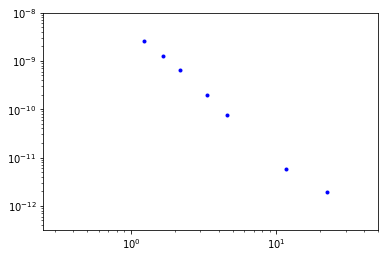

AWI0005yjn
J022317.32+381509.7
-12.0 -7.5


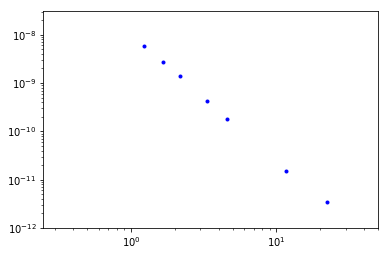

In [4]:
inputdata = get_data('sed_input_data.csv')

#print inputdata[1,:]

columnlabels = inputdata[1,:]

columncount = columnlabels.size

columnlabel_index_dict = {}

for i in range(columncount):
    columnlabel_index_dict[columnlabels[i]] = i

    
#from pprint import pprint
#pprint(columnlabel_index_dict)
    
inputdata_use = inputdata[5:,:]

#print inputdata_use.shape

num_subjs = inputdata_use[:,0].size

raw_subjs = []

for i in range(num_subjs):
    raw_subjs.append(FullSubject(inputdata_use[i,:]))
    
print "Subjects read in"

#print columnlabels
#print raw_subjs[180].sourcevec

#print raw_subjs[180].sourcevec[columnlabel_index_dict[' P_gMeanPSFMag']]

#print raw_subjs[180].filts
#print raw_subjs[180].mags
#print raw_subjs[180].magerrs
#print raw_subjs[180].fluxes
#print raw_subjs[180].fluxerrs
#print raw_subjs[180].centwavs_microns
print raw_subjs[40].zooniverse_id
print raw_subjs[40].wiseid

plt.errorbar(raw_subjs[40].centwavs_microns, raw_subjs[40].nuFnu, yerr=raw_subjs[40].nuFnuerrs, fmt='b.')
min_nuFnu_logs = min(np.log10(raw_subjs[40].nuFnu))
max_nuFnu_logs = max(np.log10(raw_subjs[40].nuFnu))

ymin = float(np.floor((min_nuFnu_logs-0.5)*2.))/2.
ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.

print ymin, ymax

plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')
plt.xlim([0.25, 50.])
plt.ylim([10.**ymin, 10.**ymax])
plt.show()

print raw_subjs[20].zooniverse_id
print raw_subjs[20].wiseid

plt.errorbar(raw_subjs[20].centwavs_microns, raw_subjs[20].nuFnu, yerr=raw_subjs[20].nuFnuerrs, fmt='b.')
min_nuFnu_logs = min(np.log10(raw_subjs[20].nuFnu))
max_nuFnu_logs = max(np.log10(raw_subjs[20].nuFnu))

ymin = float(np.floor((min_nuFnu_logs-0.5)*2.))/2.
ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.

print ymin, ymax

plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposy='clip')
plt.xlim([0.25, 50.])
plt.ylim([10.**ymin, 10.**ymax])
plt.show()

1516737065.67
AWI00062h7 J002133.47-661816.6


C:\Users\Steven Silverberg\Anaconda2\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Steven Silverberg\Anaconda2\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: overflow encountered in double_scalars


W2 significantly low. Refitting with W2 included
[  4.38169418e-09   2.03464966e-09   1.01976127e-09   3.16311886e-10
   1.24352112e-10   9.30177395e-12   2.17762819e-12]
[  4.33695022e-09   2.06511757e-09   1.03707347e-09   3.10210541e-10
   1.26390228e-10   8.66482800e-12   1.27636750e-12]
11511.5374469 None 2.17296557367e-10


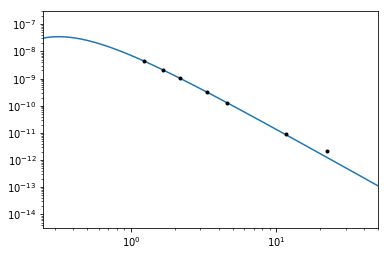

1516737068.44 1 2.76399993896
AWI0000nfp J002155.14-672715.9
W2 significantly low. Refitting with W2 included
[  9.32927720e-10   8.11730864e-10   4.31552545e-10   1.35870711e-10
   4.49302538e-11   3.95493066e-12   5.84050109e-13]
[  9.18381449e-10   7.57653581e-10   4.34389737e-10   1.36607239e-10
   5.36579661e-11   4.32062746e-12   6.02788240e-13]
4400.0 5.5 2.65882969187e-10


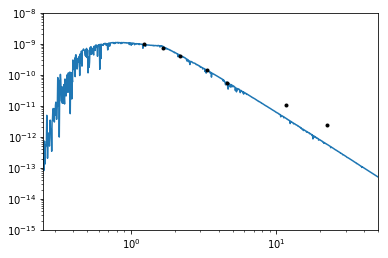

1516737079.49 2 6.9074999094
AWI0000bs0 J003140.76-014737.3
W2 significantly low. Refitting with W2 included
[  6.61975723e-09   3.23660455e-09   1.62966567e-09   5.08081728e-10
   1.95457872e-10   1.60311907e-11   5.27695913e-12]
[  6.61155900e-09   3.22616192e-09   1.64525217e-09   5.00729727e-10
   2.05681801e-10   1.42792928e-11   2.11145303e-12]
10061.9506771 None 2.99554352346e-10


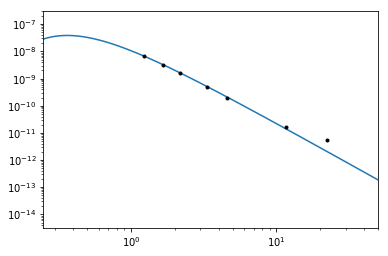

1516737081.46 3 5.26399993896
AWI0005mry J003412.66+540359.0
W2 significantly low. Refitting with W2 included
[  4.44264961e-09   2.20846052e-09   1.08467222e-09   3.19255695e-10
   1.27365899e-10   9.61536514e-12   2.00809258e-12]
[  4.45999220e-09   2.14435606e-09   1.08345074e-09   3.26319113e-10
   1.33384392e-10   9.19024837e-12   1.35582774e-12]
10885.506208 None 2.30497632758e-10


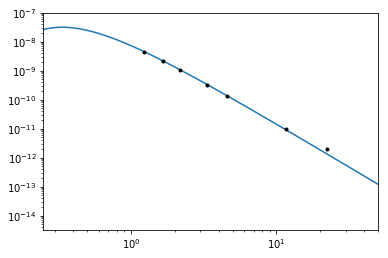

1516737083.63 4 4.4904999733
AWI0000jvv J003507.14+070625.0
W2 significantly low. Refitting with W2 included
[  2.24042328e-09   2.80927425e-09   1.46223024e-09   4.41273580e-10
   1.27385780e-10   1.32044694e-11   2.02503339e-12]
[  2.19687417e-09   2.41353032e-09   1.45700699e-09   4.47770825e-10
   1.72988123e-10   1.46261122e-11   2.09964973e-12]
3700.0 2.5 5.44103550236e-10


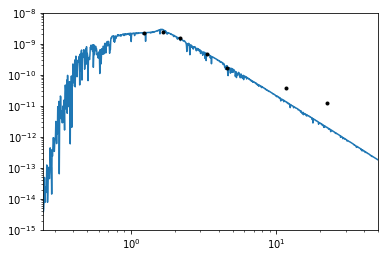

1516737095.06 5 5.8773999691
AWI00062m4 J004826.42+020753.0
W2 significantly low. Refitting with W2 included
[  1.53054485e-09   1.33171142e-09   7.07997536e-10   2.22907105e-10
   7.37117863e-11   6.48838988e-12   9.58182364e-13]
[  1.50668050e-09   1.24299318e-09   7.12652183e-10   2.24115440e-10
   8.80303180e-11   7.08834562e-12   9.88923813e-13]
4400.0 5.5 3.40556796595e-10


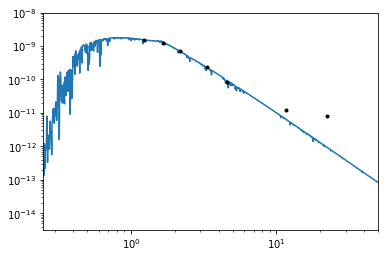

1516737105.47 6 6.63233331839
AWI0005yiv J005926.26+400918.2
W2 significantly low. Refitting with W2 included
[  5.24375102e-09   2.41262398e-09   1.24079066e-09   3.86417073e-10
   1.50887467e-10   1.11215618e-11   2.48189687e-12]
[  5.21449431e-09   2.49325127e-09   1.25534000e-09   3.76603611e-10
   1.53653481e-10   1.05564944e-11   1.55603250e-12]
11234.8372934 None 2.42946358116e-10


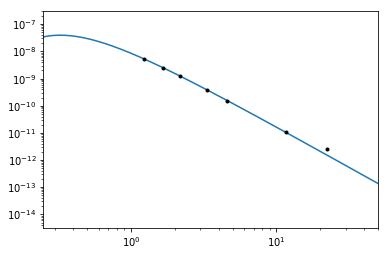

1516737107.44 7 5.967428548
AWI00055sx J010652.55+743754.5
W2 significantly low. Refitting with W2 included
[  2.09142388e-09   9.90124120e-10   5.00839434e-10   1.52367617e-10
   6.00140819e-11   4.77052066e-12   1.58337481e-12]
[  2.07570520e-09   9.97321030e-10   5.03689066e-10   1.51630904e-10
   6.19658423e-11   4.26798852e-12   6.29585237e-13]
10926.77627 None 1.56763509421e-10


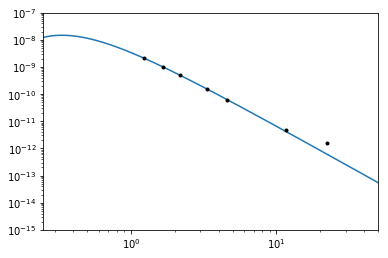

1516737109.21 8 5.44200000167
AWI00055sz J011636.23+740136.6
W2 significantly low. Refitting with W2 included
[  7.62152823e-09   3.87694500e-09   2.14238992e-09   6.36169428e-10
   2.82181757e-10   2.51284547e-11   4.70742848e-12]
[  7.70676700e-09   3.97171570e-09   2.09576554e-09   6.62619685e-10
   2.77058998e-10   1.97657243e-11   2.94681572e-12]
7928.86157908 None 4.00416412647e-10


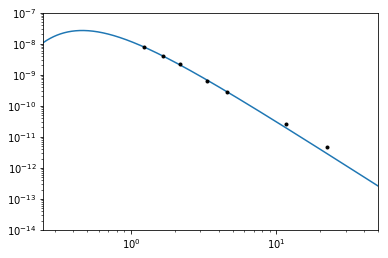

1516737111.19 9 5.05755554305
AWI00062mq J011743.47-523330.8
W2 significantly low. Refitting with W2 included
[  3.60864706e-10   3.35744162e-10   2.63955121e-10   6.90434139e-11
   5.64852795e-11   4.92759816e-12   7.35184800e-13]
[  3.45079780e-10   2.74895158e-10   2.13784378e-10   8.47169135e-11
   4.80098796e-11   5.43054268e-12   8.81984963e-13]
2200.0 2.5 4.96293657613e-10


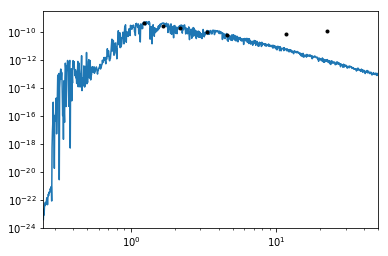

1516737120.81 10 5.5132999897
AWI0005w6c J012650.26+454038.8
W2 significantly low. Refitting with W2 included
[  3.54194703e-09   1.61766891e-09   8.08534425e-10   2.46582385e-10
   9.88674122e-11   9.41381764e-12   2.55378147e-12]
[  3.50940905e-09   1.64501104e-09   8.17939526e-10   2.41929616e-10
   9.80489297e-11   6.66674857e-12   9.79580725e-13]
12718.9341542 None 1.80858003126e-10


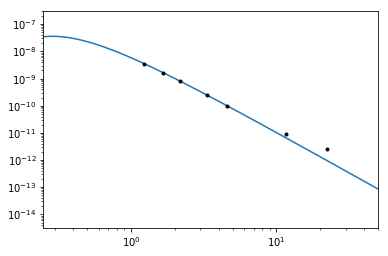

1516737122.62 11 5.17699998075
AWI0004ne5 J013525.89+560237.3
W2 significantly low. Refitting with W2 included
[  7.43433389e-09   3.42365221e-09   1.70961577e-09   5.21949471e-10
   2.07899367e-10   1.61944343e-11   4.09999881e-12]
[  7.40651442e-09   3.47059550e-09   1.72530063e-09   5.10186282e-10
   2.06744273e-10   1.40549186e-11   2.06505287e-12]
12747.5782957 None 2.62290229772e-10


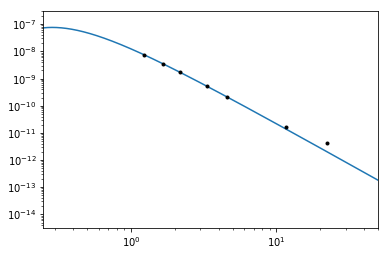

1516737124.47 12 4.89983332157
AWI00062a8 J013756.15+211539.9
W2 significantly low. Refitting with W2 included
[  2.87105864e-09   1.34427970e-09   6.98390810e-10   2.13255655e-10
   8.43049678e-11   7.22047521e-12   5.63357046e-12]
[  2.85347543e-09   1.37922098e-09   6.99183048e-10   2.11373751e-10
   8.65521741e-11   5.97973083e-12   8.82912277e-13]
10574.0799525 None 1.88807553956e-10


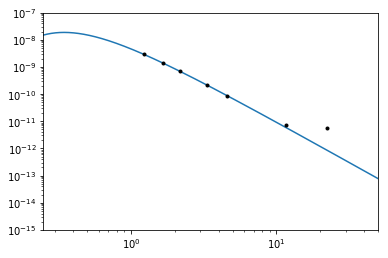

1516737126.53 13 4.68153845347
AWI0005aeg J013833.77+780834.3
W2 significantly low. Refitting with W2 included
[  7.34814601e-10   6.33784829e-10   4.11683501e-10   1.10422004e-10
   6.93056516e-11   5.45216077e-12   8.55302790e-13]
[  7.10808941e-10   5.56417089e-10   3.70006484e-10   1.32252379e-10
   6.94326892e-11   6.25570990e-12   9.81057699e-13]
2800.0 3.5 4.45507900161e-10


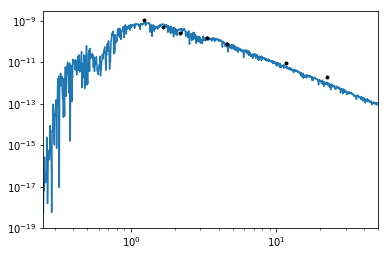

1516737136.4 14 5.05192857129
AWI00062aa J014113.00+163051.7
W2 significantly low. Refitting with W2 included
[  2.69179550e-09   1.42590188e-09   7.29959081e-10   2.28570309e-10
   9.02512377e-11   7.78692122e-12   3.50254506e-12]
[  2.72200930e-09   1.39392808e-09   7.32639335e-10   2.30624414e-10
   9.62339794e-11   6.84413673e-12   1.01942127e-12]
8123.89238237 None 2.32551129135e-10


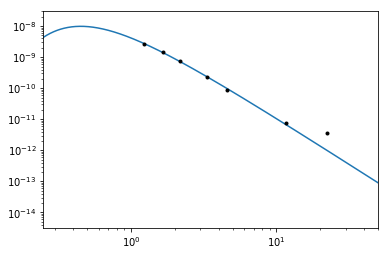

1516737138.2 15 4.8354666551
AWI0005zx4 J014928.21+244048.7
W2 significantly low. Refitting with W2 included
[  2.41235969e-09   1.18710638e-09   6.27622516e-10   1.90690901e-10
   7.63929299e-11   6.24835623e-12   1.44405499e-12]
[  2.41114762e-09   1.20240972e-09   6.21605315e-10   1.92094133e-10
   7.94705705e-11   5.57808352e-12   8.27562830e-13]
9072.91574981 None 1.97846452216e-10


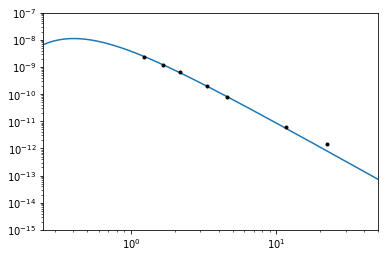

1516737140.34 16 4.66693750024
AWI00008jh J015317.94-461421.9
W2 significantly low. Refitting with W2 included
[  1.91681304e-09   2.54943426e-09   1.33987857e-09   3.27082724e-10
   1.22905305e-10   1.13886077e-11   1.80439605e-12]
[  1.86575606e-09   2.11886086e-09   1.28147847e-09   3.75409685e-10
   1.60348893e-10   1.33222807e-11   1.98974091e-12]
3400.0 2.5 5.60281650241e-10


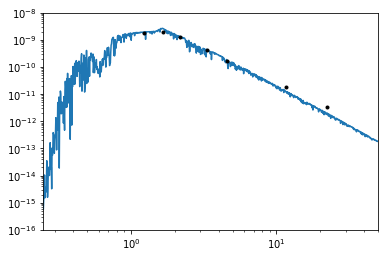

1516737151.83 17 5.06776470297
AWI00062aj J020221.16+192323.6
W2 significantly low. Refitting with W2 included
[  2.24720174e-09   1.11196122e-09   5.78760010e-10   1.72700134e-10
   6.77724470e-11   5.45714862e-12   1.68571337e-12]
[  2.26035953e-09   1.11358738e-09   5.71322709e-10   1.75057770e-10
   7.21348741e-11   5.03231833e-12   7.45215636e-13]
9597.56631908 None 1.82360345995e-10


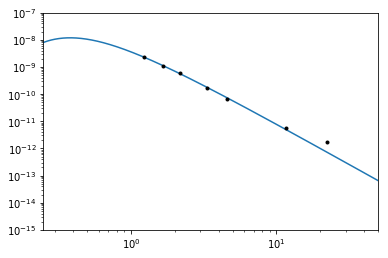

1516737153.62 18 4.8857777781
AWI0000qox J020359.52+141132.3
W2 significantly low. Refitting with W2 included
[  2.51275036e-09   3.22785046e-09   1.68591249e-09   4.89133259e-10
   1.46906232e-10   1.49190174e-11   2.31681553e-12]
[  2.46220636e-09   2.74771717e-09   1.66794184e-09   5.06961596e-10
   2.00232954e-10   1.68518726e-11   2.43705942e-12]
3600.0 2.5 5.95718645672e-10


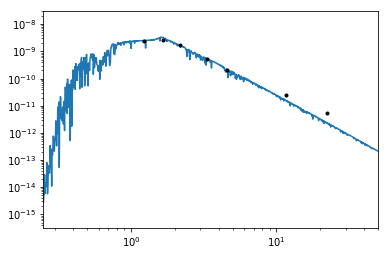

1516737164.34 19 5.19305263068
AWI0005w6v J021327.01+421923.3
W2 significantly low. Refitting with W2 included
[  1.28009459e-09   6.50563420e-10   3.27264212e-10   1.02445450e-10
   4.05744991e-11   3.53969450e-12   1.81294125e-12]
[  1.28332119e-09   6.39146403e-10   3.30149158e-10   1.01933175e-10
   4.21525542e-11   2.95678888e-12   4.38582316e-13]
9125.83857113 None 1.4359675447e-10


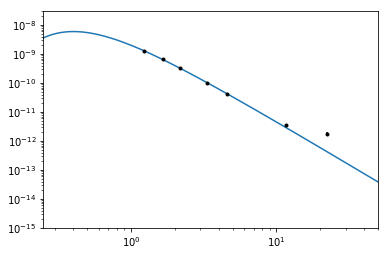

1516737166.1 20 5.02124999762
AWI0005yjn J022317.32+381509.7
W2 significantly low. Refitting with W2 included
[  5.92709738e-09   2.67725439e-09   1.39861608e-09   4.18888443e-10
   1.77931634e-10   1.53803345e-11   3.41337286e-12]
[  5.87692747e-09   2.78158919e-09   1.39157220e-09   4.14463119e-10
   1.68524328e-10   1.15171260e-11   1.69490091e-12]
11943.6389768 None 2.45703338167e-10


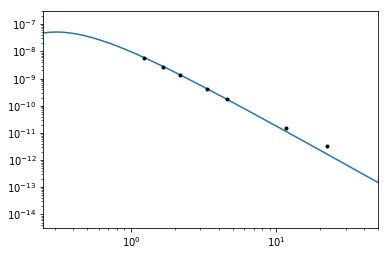

1516737168.02 21 4.87347618739
AWI0005yjp J022515.75+370707.9
W2 significantly low. Refitting with W2 included
[  4.47962915e-09   2.02716752e-09   1.03394757e-09   3.02556852e-10
   1.18755345e-10   9.97621457e-12   3.40395438e-12]
[  4.43703696e-09   2.06744839e-09   1.02410478e-09   3.01611943e-10
   1.21988919e-10   8.26835496e-12   1.21374112e-12]
13254.7236342 None 1.97103319609e-10


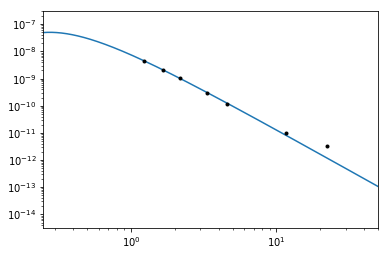

1516737169.92 22 4.73868181489
AWI0005yjq J023047.36+360701.7
W2 significantly low. Refitting with W2 included
[  3.85515694e-09   1.86934577e-09   9.26613271e-10   2.89402790e-10
   1.14565318e-10   8.68891965e-12   3.81578354e-12]
[  3.84098214e-09   1.85827294e-09   9.42589712e-10   2.85148499e-10
   1.16797450e-10   8.07320635e-12   1.19218978e-12]
10520.8802431 None 2.19969629421e-10


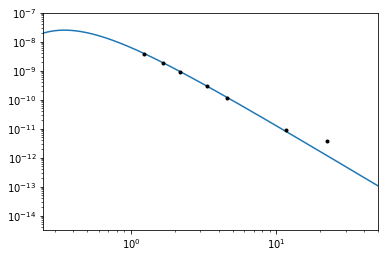

1516737171.71 23 4.61039129547
AWI0000b9g J023115.97-094845.9
W2 significantly low. Refitting with W2 included
[  4.28899922e-12   3.75681690e-12   2.48222790e-12   1.14560214e-12
   4.05925974e-13   6.70574206e-14   6.43795711e-15]
[  3.44057534e-12   3.19064621e-12   2.17113849e-12   1.03438374e-12
   4.36156327e-13   6.07511903e-14   8.52261246e-15]
2000.0 5.5 5.9524328528e-11


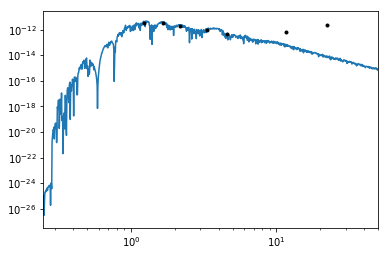

1516737183.39 24 4.90470832586
AWI0005w77 J023720.84+395345.8
W2 significantly low. Refitting with W2 included
[  8.24217938e-09   3.57840622e-09   1.74782729e-09   5.08553706e-10
   2.01675511e-10   1.88871218e-11   5.64915812e-12]
[  8.13943024e-09   3.62678351e-09   1.74601090e-09   4.97736470e-10
   1.98212334e-10   1.31121982e-11   1.91047666e-12]
19696.8011457 None 2.02037303515e-10


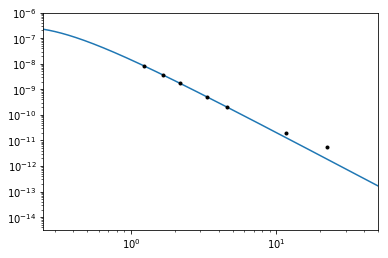

1516737185.49 25 4.79255999565
AWI0005zfw J024430.00+280053.8
W2 significantly low. Refitting with W2 included
[  3.59452958e-09   1.71589078e-09   9.00530685e-10   2.71745426e-10
   1.05451598e-10   8.32848065e-12   1.99518757e-12]
[  3.57546185e-09   1.74514159e-09   8.90122780e-10   2.70958465e-10
   1.11309851e-10   7.72864937e-12   1.14286847e-12]
10048.3074772 None 2.2053998061e-10


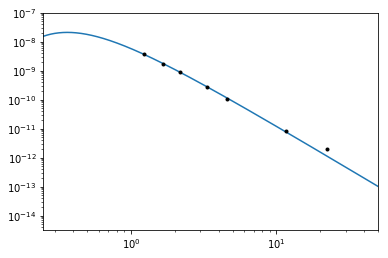

1516737187.34 26 4.67949999296
AWI000425z J024755.37+553648.4
W2 significantly low. Refitting with W2 included
[  8.67844794e-09   4.08215640e-09   2.08016850e-09   6.40917865e-10
   2.55305371e-10   1.86967354e-11   4.23432053e-12]
[  8.63638056e-09   4.14085159e-09   2.08854296e-09   6.27800795e-10
   2.56378913e-10   1.76393517e-11   2.60118318e-12]
11057.1772578 None 3.16701378136e-10


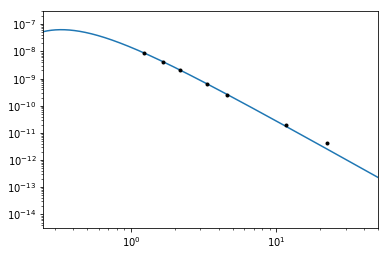

1516737189.15 27 4.57337036839
AWI0000c52 J025149.66-244328.9
W2 significantly low. Refitting with W2 included
[  2.06898739e-09   1.67541310e-09   8.51419376e-10   2.64201752e-10
   7.38667036e-11   7.47908934e-12   1.09577139e-12]
[  2.01666123e-09   1.54554099e-09   8.61171012e-10   2.64657107e-10
   1.01681994e-10   8.14247939e-12   1.13389964e-12]
4800.0 2.5 3.52935580742e-10


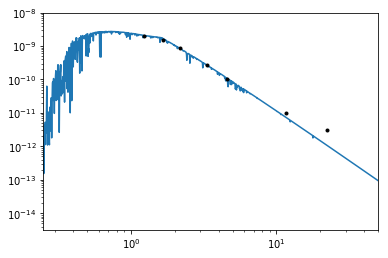

1516737203.44 28 4.92014285496
AWI0000phh J025614.05+040254.2
W2 significantly low. Refitting with W2 included
[  3.32691774e-09   1.54343960e-09   7.73568035e-10   2.40721905e-10
   9.45917296e-11   7.70133085e-12   2.41425829e-12]
[  3.27121194e-09   1.56427666e-09   7.87664072e-10   2.36319969e-10
   9.64218408e-11   6.62489765e-12   9.76531266e-13]
11227.1793332 None 1.92529169552e-10


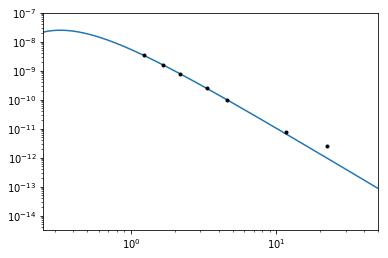

1516737205.2 29 4.8111379311
AWI0000xbv J025926.83+593531.6
W2 significantly low. Refitting with W2 included
[  5.48582643e-09   2.82936932e-09   1.47264652e-09   4.54524608e-10
   1.79412694e-10   1.37964001e-11   2.94024643e-12]
[  5.51051270e-09   2.80542609e-09   1.46914333e-09   4.60591028e-10
   1.91831212e-10   1.36037186e-11   2.02449428e-12]
8313.86103031 None 3.23801579833e-10


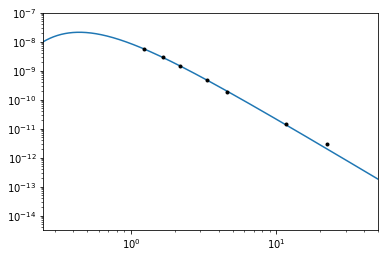

1516737207.1 30 4.7140999953
AWI0005yk3 J030651.95+303136.8
W2 significantly low. Refitting with W2 included
[  9.99176158e-09   5.21062286e-09   2.80607010e-09   7.89366159e-10
   3.54296095e-10   4.59796627e-11   2.24689993e-11]
[  1.01258725e-08   5.13989724e-09   2.68669886e-09   8.40578438e-10
   3.49757710e-10   2.47668900e-11   3.68417045e-12]
8413.67177538 None 4.341070907e-10


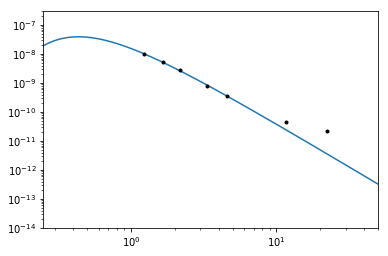

1516737209.17 31 4.62880644491
AWI00062ic J030854.20-185809.1
W2 significantly low. Refitting with W2 included
[  8.02319061e-09   5.19889650e-09   2.62019006e-09   7.92546878e-10
   2.81992777e-10   2.22760399e-11   3.25731097e-12]
[  7.92906932e-09   4.93934990e-09   2.65998182e-09   8.01812507e-10
   3.20503900e-10   2.42630802e-11   3.36948776e-12]
5800.0 2.5 5.55891554726e-10


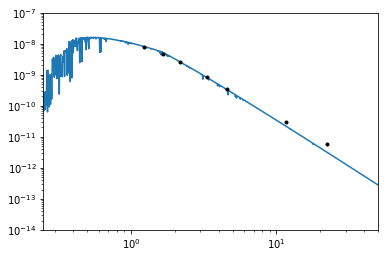

1516737221.75 32 4.87728124857
AWI00055vo J031738.10+731810.2
W2 significantly low. Refitting with W2 included
W2 significantly low. Refitting with W2 included
[  1.22772589e-09   7.81925677e-10   3.93357194e-10   1.18871916e-10
   4.41054530e-11   3.34035242e-12   4.88420096e-13]
[  1.21360265e-09   7.42889287e-10   3.99698916e-10   1.20372458e-10
   4.82933822e-11   3.63915234e-12   5.05380157e-13]
5900.0 2.5 2.13312952858e-10


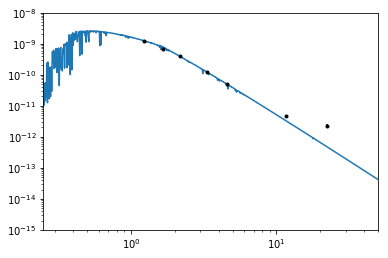

1516737232.68 33 5.060757572
AWI0005w7o J032429.84+341709.9
W2 significantly low. Refitting with W2 included
[  2.60160922e-09   1.34057044e-09   7.02260944e-10   2.17839198e-10
   8.48502579e-11   7.83007246e-12   3.02262125e-12]
[  2.61749650e-09   1.33365855e-09   6.98761778e-10   2.19191896e-10
   9.13149142e-11   6.47818675e-12   9.64194147e-13]
8287.00107003 None 2.23837866117e-10


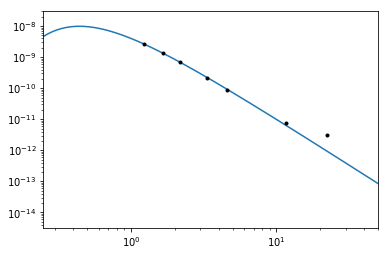

1516737234.71 34 4.97167646885
AWI0005ykd J032448.99+283908.6
W2 significantly low. Refitting with W2 included
[  7.11937817e-09   3.37046359e-09   1.75427840e-09   5.07139094e-10
   2.06944156e-10   1.52955741e-11   3.72206309e-12]
[  7.11106045e-09   3.40336653e-09   1.71462428e-09   5.14743559e-10
   2.10082320e-10   1.44405780e-11   2.12887284e-12]
11172.076102 None 2.84988995699e-10


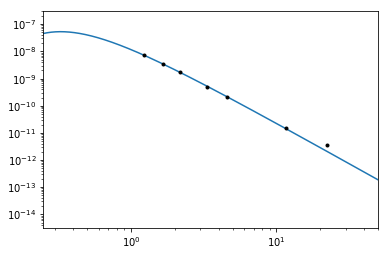

1516737236.54 35 4.88191428185
AWI0005zy4 J032504.59+105835.0
W2 significantly low. Refitting with W2 included
[  6.01508907e-09   2.87931805e-09   1.49450893e-09   4.44513900e-10
   1.77440669e-10   1.34575432e-11   2.86803027e-12]
[  6.01716772e-09   2.92167742e-09   1.48536695e-09   4.50498799e-10
   1.84747080e-10   1.27936831e-11   1.89033668e-12]
10320.9905444 None 2.79741274262e-10


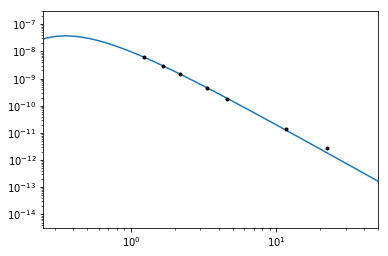

1516737238.46 36 4.79952777757
AWI00062iw J032555.87-355515.1
W2 significantly low. Refitting with W2 included
[  1.22586335e-08   5.96608780e-09   3.09669559e-09   9.71499152e-10
   3.82318847e-10   2.86131572e-11   6.57633201e-12]
[  1.22107060e-08   6.03661129e-09   3.10379653e-09   9.53343554e-10
   3.93284862e-10   2.74846166e-11   4.07223784e-12]
9441.18951162 None 4.29928948627e-10


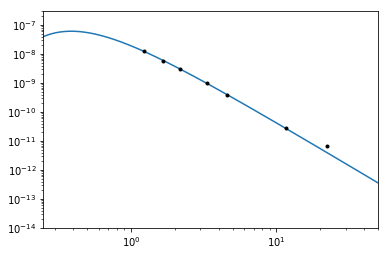

1516737240.61 37 4.72805405307
AWI0000zqw J032847.84+575556.1
W2 significantly low. Refitting with W2 included
[  3.82697480e-11   4.77990940e-11   4.93447880e-11   2.30798750e-11
   1.68440482e-11   2.23432569e-12   2.17830011e-13]
[  3.83557702e-11   3.97995613e-11   4.02427046e-11   2.25881841e-11
   1.27891538e-11   2.15751799e-12   3.59229816e-13]
1600.0 2.5 3.98193643104e-10


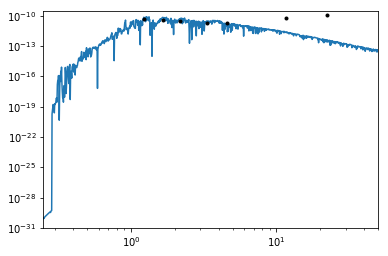

1516737252.49 38 4.91636841548
AWI0000mb7 J033337.91-072453.8
W2 significantly low. Refitting with W2 included
[  6.60757441e-09   3.54233508e-09   1.87455642e-09   5.89489890e-10
   2.31128322e-10   1.91146250e-11   5.21895714e-12]
[  6.63907077e-09   3.49392881e-09   1.86781049e-09   5.99138697e-10
   2.52196704e-10   1.81761081e-11   2.71809674e-12]
7353.31234812 None 3.99981671765e-10


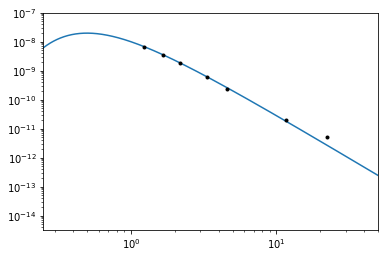

1516737254.54 39 4.8427179471
AWI0000xcq J033421.19+564343.6
W2 significantly low. Refitting with W2 included
[  7.03796588e-11   1.06809829e-10   1.22329962e-10   8.24375368e-11
   6.05812223e-11   8.72043268e-12   8.10082534e-13]
[  7.23472890e-11   9.33834339e-11   1.09516288e-10   7.59054351e-11
   4.63055841e-11   8.47122040e-12   1.44598547e-12]
1500.0 2.5 8.05545544461e-10


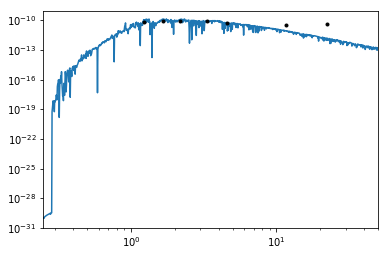

1516737266.87 40 5.02989999652
AWI0002d6a J033549.39+641324.7
W2 significantly low. Refitting with W2 included
[  2.60400649e-09   1.23392749e-09   6.47587587e-10   1.94787158e-10
   7.66748909e-11   5.85282827e-12   1.91242200e-12]
[  2.59244702e-09   1.26087218e-09   6.41690120e-10   1.94847202e-10
   7.99497025e-11   5.54119196e-12   8.18951940e-13]
10232.1548068 None 1.84949626341e-10


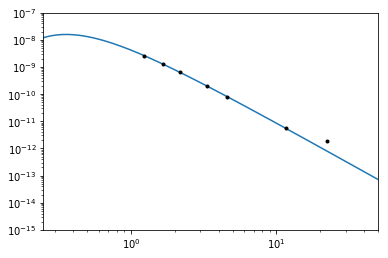

1516737269.04 41 4.96029268242
AWI00062j7 J033709.08-294948.5
W2 significantly low. Refitting with W2 included
[  5.10554446e-09   2.45069712e-09   1.25111870e-09   3.85343650e-10
   1.52283611e-10   1.15602115e-11   2.50486158e-12]
[  5.08523205e-09   2.46905303e-09   1.25521763e-09   3.80683834e-10
   1.56113905e-10   1.08105829e-11   1.59731108e-12]
10323.5420063 None 2.57114360752e-10


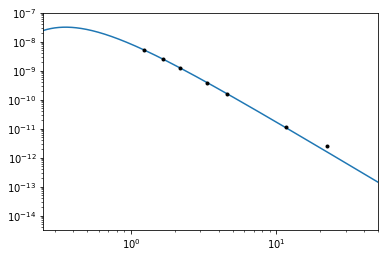

1516737270.72 42 4.8821904716
AWI0005ylv J033900.56+294145.6
W2 significantly low. Refitting with W2 included
[  4.52617062e-10   5.65320823e-10   5.83601777e-10   2.72966135e-10
   1.99214890e-10   2.64254138e-11   2.57627982e-12]
[  4.53634447e-10   4.70710194e-10   4.75951258e-10   2.67150897e-10
   1.51257574e-10   2.55170077e-11   4.24861809e-12]
1600.0 2.5 1.36940522823e-09


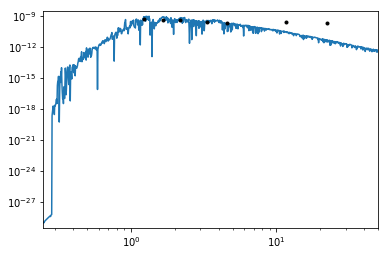

1516737278.21 43 4.94276743711
AWI0005ylw J033906.73+244209.8
W2 significantly low. Refitting with W2 included
[  6.25233245e-09   2.86081412e-09   1.42461829e-09   4.48241685e-10
   1.75006092e-10   1.31149241e-11   3.65076376e-12]
[  6.18363986e-09   2.90626171e-09   1.44749942e-09   4.28958245e-10
   1.74004566e-10   1.18478888e-11   1.74161840e-12]
12495.1319678 None 2.43360193931e-10


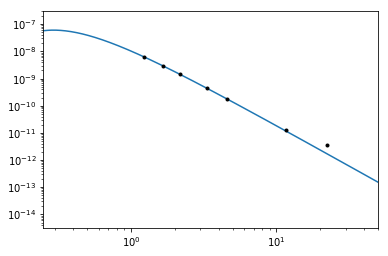

1516737280.05 44 4.87211363424
AWI0005ylz J034400.28+243324.6
W2 significantly low. Refitting with W2 included
[  3.42327716e-09   1.65687460e-09   8.57627139e-10   2.69491014e-10
   1.06918576e-10   9.55357201e-12   2.77705020e-12]
[  3.37392268e-09   1.67566010e-09   8.64045196e-10   2.66251747e-10
   1.10002935e-10   7.70533936e-12   1.14245415e-12]
9242.21891386 None 2.30243800019e-10


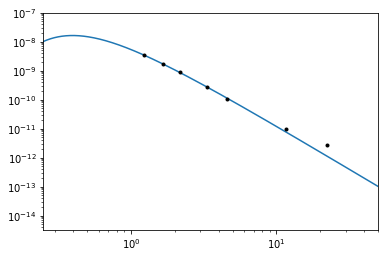

1516737282.04 45 4.80822221968
AWI0005ym7 J034921.76+242251.0
W2 significantly low. Refitting with W2 included
[  8.84793783e-09   4.11613528e-09   2.02347813e-09   6.17526560e-10
   2.43502627e-10   2.08240780e-11   7.68393585e-12]
[  8.82967940e-09   4.11399393e-09   2.03778723e-09   6.00131579e-10
   2.42722768e-10   1.64511810e-11   2.41490647e-12]
13259.6801488 None 2.77969961542e-10


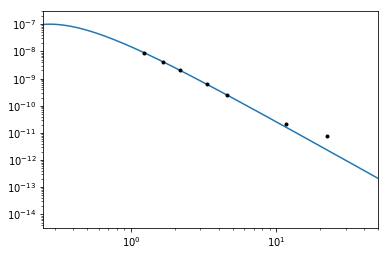

1516737283.92 46 4.74445651925
AWI0005zyr J035007.87+095528.1
W2 significantly low. Refitting with W2 included
W2 significantly low. Refitting with W2 included
[  5.65904183e-09   3.49709126e-09   1.75117113e-09   5.28592204e-10
   2.09813669e-10   1.49635204e-11   2.18763577e-12]
[  5.60167630e-09   3.32939702e-09   1.78473797e-09   5.36004729e-10
   2.17034669e-10   1.63245692e-11   2.26495552e-12]
6100.0 2.5 4.42117772671e-10


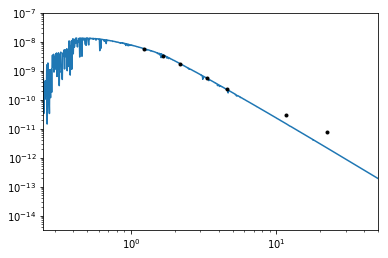

1516737293.37 47 4.84451063643
AWI0005ym9 J035157.43+255955.4
W2 significantly low. Refitting with W2 included
[  4.61362256e-09   2.15620297e-09   1.12953194e-09   3.44457269e-10
   1.36726648e-10   1.03030494e-11   2.23451735e-12]
[  4.54489536e-09   2.20354616e-09   1.11923278e-09   3.39099330e-10
   1.38994667e-10   9.61806718e-12   1.42079632e-12]
10401.5337663 None 2.41552336102e-10


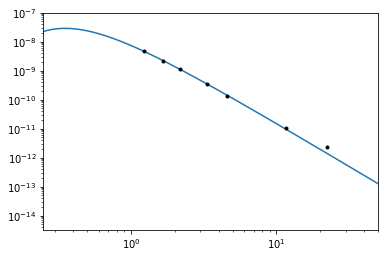

1516737295.18 48 4.78141666452
AWI0005w9s J035958.81+312901.0
W2 significantly low. Refitting with W2 included
[  8.12909244e-10   4.31012276e-10   2.33183875e-10   7.36703400e-11
   2.94207112e-11   2.70499073e-12   3.63733859e-12]
[  8.14983724e-10   4.31035428e-10   2.31137283e-10   7.43954306e-11
   3.13648181e-11   2.26591630e-12   3.39092735e-13]
7230.38811356 None 1.42525833896e-10


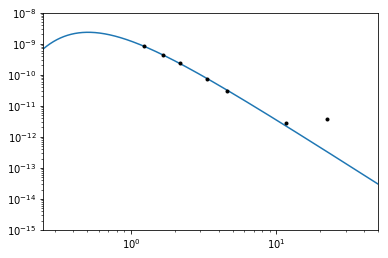

1516737297.01 49 4.72114285644
AWI0005ymc J040040.65+202447.8
W2 significantly low. Refitting with W2 included
[  3.60115705e-09   1.79015090e-09   9.40369459e-10   2.98936078e-10
   1.16052144e-10   9.45726985e-12   8.10557317e-12]
[  3.56494406e-09   1.81038854e-09   9.46584102e-10   2.96247951e-10
   1.23284383e-10   8.73191728e-12   1.29899397e-12]
8398.18607206 None 2.58015817755e-10


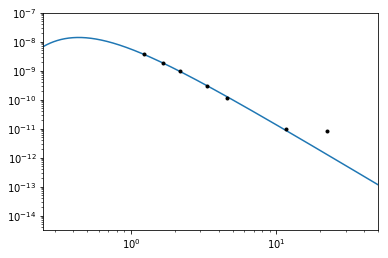

1516737299.04 50 4.66725999832
AWI0005zz5 J040238.47-004803.7
W2 significantly low. Refitting with W2 included
[  7.13907694e-09   3.17168202e-09   1.67686660e-09   5.12821378e-10
   2.04858112e-10   1.48513448e-11   3.79825161e-12]
[  6.97696531e-09   3.30540641e-09   1.65462688e-09   4.93147694e-10
   2.00582820e-10   1.37148949e-11   2.01863990e-12]
11872.6468921 None 2.68966770293e-10


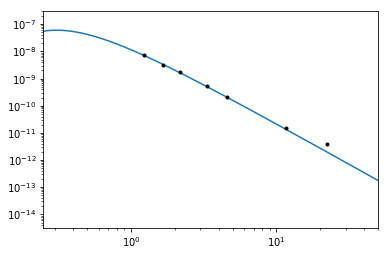

1516737300.86 51 4.61147058711
AWI00055vx J040649.32+702738.0
W2 significantly low. Refitting with W2 included
[  2.04005587e-09   9.78339617e-10   5.05008300e-10   1.62664459e-10
   6.30744056e-11   5.05086524e-12   1.80793882e-12]
[  1.98750407e-09   9.90383562e-10   5.11749375e-10   1.58060649e-10
   6.53743351e-11   4.58689834e-12   6.80432014e-13]
9104.12265319 None 1.79080166166e-10


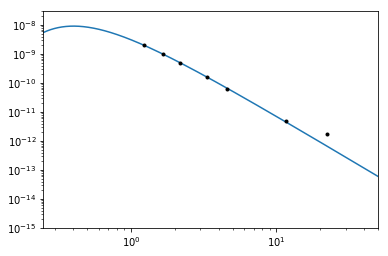

1516737302.62 52 4.55674999952
AWI0005ymi J041249.03+193219.2
W2 significantly low. Refitting with W2 included
W2 significantly low. Refitting with W2 included
[  7.40699519e-09   4.13894485e-09   2.11689109e-09   7.11260843e-10
   2.84146480e-10   2.21700045e-11   6.18277911e-12]
[  7.46504536e-09   3.99569776e-09   2.15859057e-09   7.00499456e-10
   2.96447106e-10   2.15397139e-11   3.22892510e-12]
6952.54417677 None 4.48920340798e-10


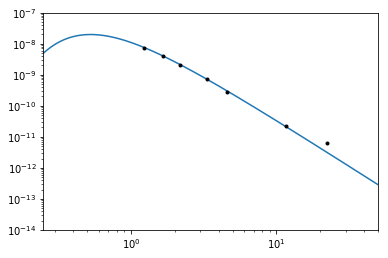

1516737304.77 53 4.51120754458
AWI0002ozm J041517.47+505124.0
W2 significantly low. Refitting with W2 included
[  1.59529889e-09   8.04803099e-10   4.41874069e-10   1.33073835e-10
   5.83785316e-11   7.59566463e-12   2.65695213e-12]
[  1.59742775e-09   8.18477434e-10   4.30331080e-10   1.35512806e-10
   5.65560388e-11   4.02331903e-12   5.99313548e-13]
8106.85525724 None 1.78501994035e-10


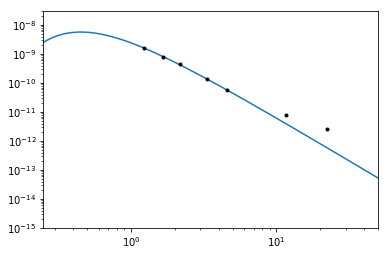

1516737306.5 54 4.4598148134
AWI00062df J043026.69-431245.6
W2 significantly low. Refitting with W2 included
[  4.52941446e-09   2.10906342e-09   1.10483778e-09   3.31615985e-10
   1.31417490e-10   1.05333322e-11   3.24476860e-12]
[  4.52127116e-09   2.17561346e-09   1.09981474e-09   3.31441551e-10
   1.35515477e-10   9.34105274e-12   1.37825375e-12]
10835.5785101 None 2.32947102879e-10


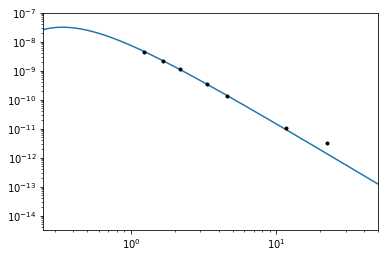

1516737308.28 55 4.41098181551
AWI0006006 J043217.75-133511.5
W2 significantly low. Refitting with W2 included
[  9.63922377e-10   4.82713717e-10   2.47798410e-10   7.77128210e-11
   3.05811045e-11   3.13737030e-12   2.63501888e-12]
[  9.62637291e-10   4.81833172e-10   2.49667561e-10   7.73539753e-11
   3.20403927e-11   2.25309164e-12   3.34454307e-13]
8925.89600725 None 1.26845099013e-10


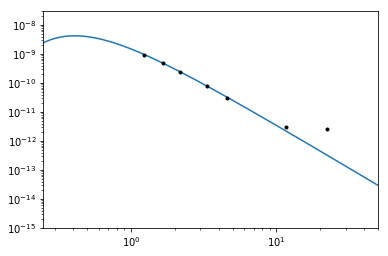

1516737310.26 56 4.36766071405
AWI000600b J043521.12-081730.0
W2 significantly low. Refitting with W2 included
[  3.16549814e-09   1.52647480e-09   7.33328419e-10   2.35654408e-10
   9.21834944e-11   6.90821398e-12   1.83140220e-12]
[  3.15101802e-09   1.52125891e-09   7.70621474e-10   2.32778127e-10
   9.52797117e-11   6.57875230e-12   9.71181472e-13]
10641.1729599 None 1.97376165978e-10


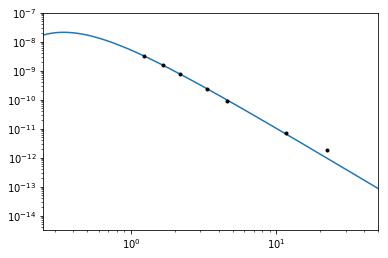

1516737312.11 57 4.32347368357
AWI0005wbq J043630.82+184215.2
W2 significantly low. Refitting with W2 included
[  1.43148811e-09   1.25791648e-09   7.37179804e-10   1.61423067e-10
   2.50540891e-10   7.66281994e-11   8.56623246e-12]
[  1.07910287e-09   1.02402469e-09   5.95277273e-10   2.93977072e-10
   2.73951671e-10   6.78557363e-11   1.16467437e-11]
1200.0 5.0 2.96012733353e-09


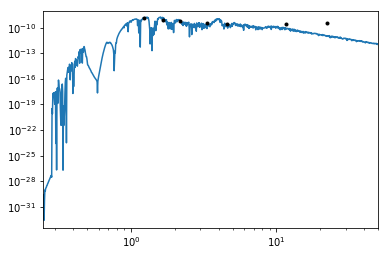

1516737321.61 58 4.41267241281
AWI000600n J043852.53-081329.6
W2 significantly low. Refitting with W2 included
[  4.82216495e-09   2.22274499e-09   1.11711663e-09   3.42547295e-10
   1.33984070e-10   1.09185705e-11   2.63016946e-12]
[  4.79191880e-09   2.26850486e-09   1.13503117e-09   3.38104149e-10
   1.37485447e-10   9.39688793e-12   1.38292362e-12]
11928.598362 None 2.22084966341e-10


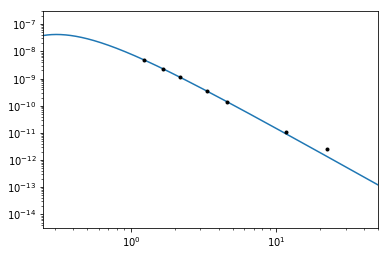

1516737323.46 59 4.3693559291
AWI0005yn2 J044717.93+054717.4
W2 significantly low. Refitting with W2 included
[  8.45750109e-09   3.87337585e-09   1.99020822e-09   6.14092629e-10
   2.37224454e-10   1.77732063e-11   4.19550005e-12]
[  8.40112105e-09   3.98637298e-09   1.99748677e-09   5.96002108e-10
   2.42546039e-10   1.65977481e-11   2.44356576e-12]
11758.0914557 None 2.97402877134e-10


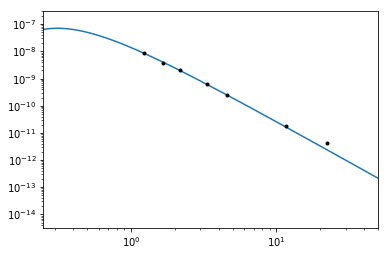

1516737325.54 60 4.33119999965
AWI0005yn4 J045013.22+034100.3
W2 significantly low. Refitting with W2 included
[  5.89443336e-09   2.88994542e-09   1.56494297e-09   4.78773002e-10
   1.91184714e-10   1.46881054e-11   3.53495371e-12]
[  5.86924301e-09   2.96014508e-09   1.54112127e-09   4.80015524e-10
   1.99315563e-10   1.40689985e-11   2.09081452e-12]
8640.08523551 None 3.22548767059e-10


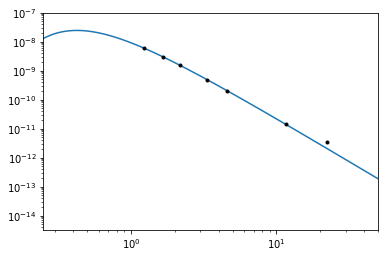

1516737327.44 61 4.29129507893
AWI0005zgy J045245.95-062129.5
W2 significantly low. Refitting with W2 included
[  2.42126354e-09   1.17839161e-09   6.15599865e-10   1.88240025e-10
   7.42425990e-11   5.90698382e-12   2.40981515e-12]
[  2.41819738e-09   1.19404617e-09   6.13470487e-10   1.88270845e-10
   7.76371166e-11   5.42235804e-12   8.03252283e-13]
9494.86524203 None 1.90384773554e-10


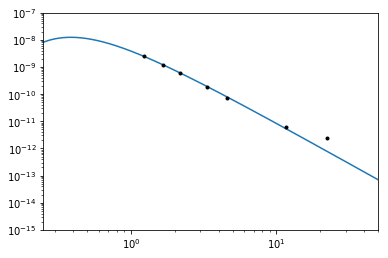

1516737329.41 62 4.25388709576
AWI0005wcl J045519.57+163712.9
W2 significantly low. Refitting with W2 included
[  6.20643287e-09   2.94096354e-09   1.48627275e-09   4.61752315e-10
   1.83760924e-10   1.42090742e-11   3.56437780e-12]
[  6.15492192e-09   2.95961985e-09   1.49547803e-09   4.50452756e-10
   1.84131721e-10   1.26875254e-11   1.87181149e-12]
10878.4281643 None 2.70919820365e-10


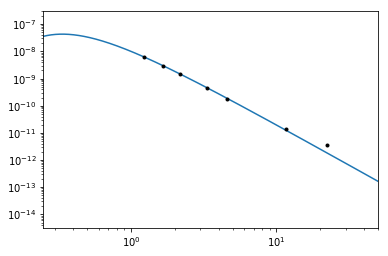

1516737331.31 63 4.21641269563
AWI0005zh6 J050206.31-085046.6
W2 significantly low. Refitting with W2 included
[  1.48022421e-10   1.84880695e-10   1.90859239e-10   8.92699625e-11
   6.51505936e-11   8.64208193e-12   8.42538227e-13]
[  1.48355143e-10   1.53939540e-10   1.55653561e-10   8.73681660e-11
   4.94667880e-11   8.34499972e-12   1.38945433e-12]
1600.0 2.5 7.83123529025e-10


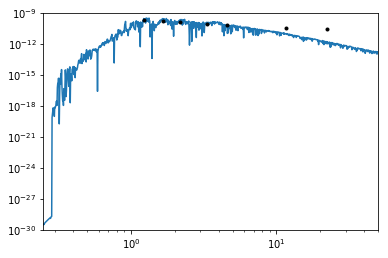

1516737338.85 64 4.26839062199
AWI0005wcz J050610.47+062929.2
W2 significantly low. Refitting with W2 included
W2 significantly low. Refitting with W2 included
[  1.01525300e-09   6.17359798e-10   3.09143392e-10   9.31005255e-11
   3.76413471e-11   2.64158847e-12   3.86016967e-13]
[  1.00449872e-09   5.87755857e-10   3.14489276e-10   9.44495732e-11
   3.83849069e-11   2.87920844e-12   3.99476334e-13]
6200.0 2.5 1.84057560981e-10


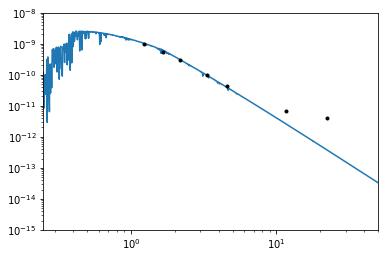

1516737348.63 65 4.35323076615
AWI0005zhi J050730.59-061059.9
W2 significantly low. Refitting with W2 included
[  3.07860498e-10   4.67216348e-10   5.35105793e-10   3.60605061e-10
   2.64999371e-10   3.81456346e-11   3.54352972e-12]
[  3.16467469e-10   4.08485505e-10   4.79055164e-10   3.32031804e-10
   2.02553698e-10   3.70555097e-11   6.32514872e-12]
1500.0 2.5 1.6847811908e-09


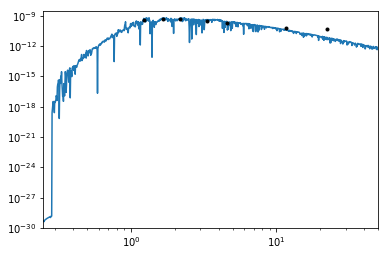

1516737359.17 66 4.44698484739
AWI0005wd8 J051143.75+122012.5
W2 significantly low. Refitting with W2 included
W2 significantly low. Refitting with W2 included
[  2.14084887e-09   1.36348408e-09   6.85917202e-10   2.07283083e-10
   7.69089503e-11   5.82474459e-12   8.51683280e-13]
[  2.11622146e-09   1.29541432e-09   6.96975590e-10   2.09899656e-10
   8.42116582e-11   6.34577740e-12   8.81257413e-13]
5900.0 2.5 2.81682279241e-10


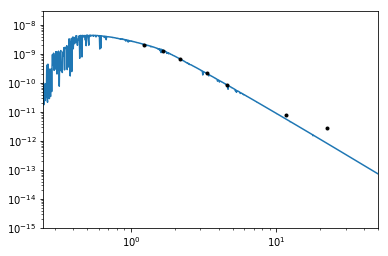

1516737369.02 67 4.52764179102
AWI0005yo4 J051328.63-043910.6
W2 significantly low. Refitting with W2 included
[  4.57975307e-09   2.28081279e-09   1.17516410e-09   3.63818297e-10
   1.42643888e-10   1.06602105e-11   2.38552367e-12]
[  4.57899655e-09   2.27927118e-09   1.17694514e-09   3.63240487e-10
   1.50184285e-10   1.05317612e-11   1.56205247e-12]
9148.51545322 None 2.70650296503e-10


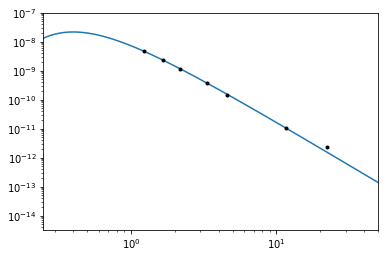

1516737370.89 68 4.48857352663
AWI0005wdi J051604.02+061852.6
W2 significantly low. Refitting with W2 included
[  8.67304898e-11   1.31624235e-10   1.50750057e-10   1.01589693e-10
   7.46556487e-11   1.07463919e-11   9.98283541e-13]
[  8.91552463e-11   1.15078577e-10   1.34959468e-10   9.35400324e-11
   5.70634478e-11   1.04392818e-11   1.78192152e-12]
1500.0 2.5 8.94236558399e-10


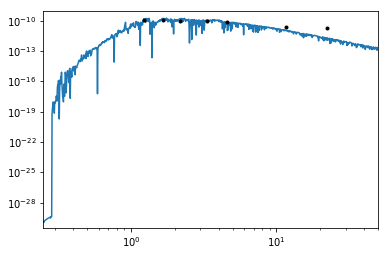

1516737378.73 69 4.53711594015
AWI0005wdq J051740.83+090514.5
W2 significantly low. Refitting with W2 included
[  1.55740670e-10   1.50302464e-10   1.15554729e-10   3.53085504e-11
   2.08445687e-11   2.27925499e-12   2.53696310e-13]
[  1.46513331e-10   1.33513359e-10   9.84313851e-11   3.94391689e-11
   1.90936188e-11   2.29509603e-12   3.45317678e-13]
2150.0 4.5 3.37223273941e-10


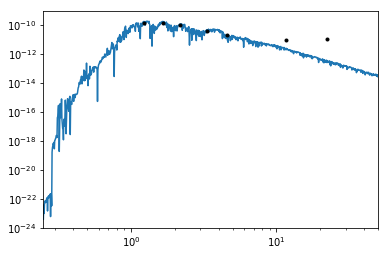

1516737388.78 70 4.61587142604
AWI0005yor J052007.77-055046.0
W2 significantly low. Refitting with W2 included
[  1.97534093e-09   9.03836010e-10   4.60573043e-10   1.33688076e-10
   5.25113480e-11   1.17102396e-11   1.37779223e-11]
[  1.96472801e-09   9.17126210e-10   4.54816662e-10   1.34123632e-10
   5.42805917e-11   3.68264325e-12   5.40746628e-13]
13087.3561386 None 1.32420742213e-10


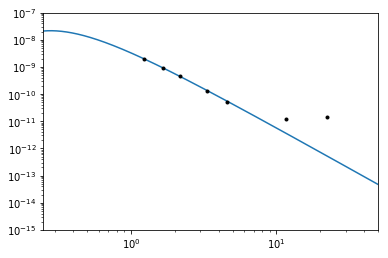

1516737390.67 71 4.57747887222
AWI0005yp1 J052104.79-102057.0
W2 significantly low. Refitting with W2 included
[  9.13780871e-10   4.99907486e-10   2.60674480e-10   8.38866158e-11
   3.53063780e-11   8.15390752e-12   5.22857968e-12]
[  9.28410891e-10   4.89829198e-10   2.62267499e-10   8.42739222e-11
   3.55020724e-11   2.56179611e-12   3.83236415e-13]
7290.17798967 None 1.50868308395e-10


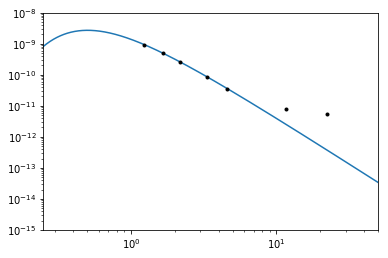

1516737392.39 72 4.53776388698
AWI0005we7 J052252.94+005557.8
W2 significantly low. Refitting with W2 included
[  5.18133965e-10   2.59471487e-10   1.29210711e-10   4.18497313e-11
   1.64381586e-11   1.64499954e-12   2.53269989e-12]
[  5.15999068e-10   2.57417236e-10   1.33106693e-10   4.11444350e-11
   1.70237609e-11   1.19512760e-12   1.77318642e-13]
9058.01649811 None 9.16589425641e-11


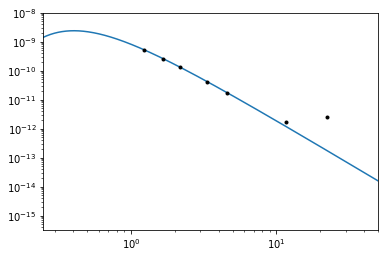

1516737394.36 73 4.50254794343
AWI0005yp9 J052303.81-044043.7
W2 significantly low. Refitting with W2 included
[  8.80787799e-11   8.84169138e-11   7.48439973e-11   2.01163480e-11
   1.70161836e-11   1.62915410e-12   2.44863133e-13]
[  8.43230670e-11   7.09894763e-11   5.85602400e-11   2.47512426e-11
   1.41174903e-11   1.76226053e-12   2.86212148e-13]
2000.0 2.5 2.98230575157e-10


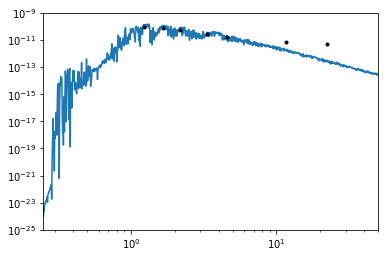

1516737403.54 74 4.56577026844
AWI0005web J052331.01-010423.6
W2 significantly low. Refitting with W2 included
[  7.79494890e-10   9.73592757e-10   1.00507613e-09   4.70100942e-10
   3.43086908e-10   4.55097185e-11   4.43685651e-12]
[  7.81247026e-10   8.10654793e-10   8.19680929e-10   4.60085969e-10
   2.60495054e-10   4.39452658e-11   7.31694930e-12]
1600.0 2.5 1.79710377895e-09


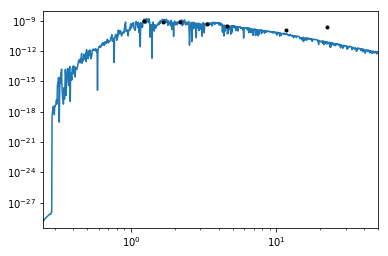

1516737416.38 75 4.6761199983
AWI0005wee J052408.04+022746.9
W2 significantly low. Refitting with W2 included
[  5.80725518e-10   8.81322732e-10   1.00938442e-09   6.80219002e-10
   4.99875423e-10   7.19551341e-11   6.68425519e-12]
[  5.96961077e-10   7.70537169e-10   9.03654610e-10   6.26320500e-10
   3.82082476e-10   6.98988023e-11   1.19312977e-11]
1500.0 2.5 2.31393937545e-09


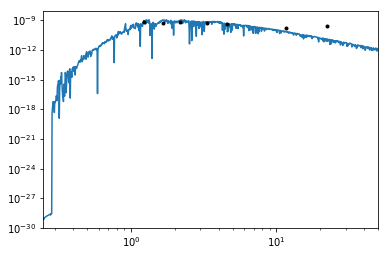

1516737425.91 76 4.73997368311
AWI0005wef J052411.19+033521.5
W2 significantly low. Refitting with W2 included
[  1.16138223e-10   1.05739983e-10   7.34109528e-11   2.40410275e-11
   1.22536663e-11   1.39240653e-12   1.47998491e-13]
[  9.32932625e-11   8.68356098e-11   6.04097077e-11   2.43837722e-11
   1.13360404e-11   1.34888213e-12   1.99614437e-13]
2200.0 5.0 2.57219630053e-10


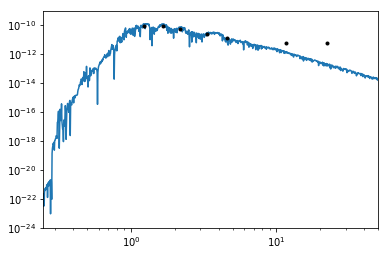

1516737436.57 77 4.81681818157
AWI0005ypj J052437.25-084201.9
W2 significantly low. Refitting with W2 included
[  1.76006052e-09   1.34862642e-09   6.85667058e-10   2.11205610e-10
   6.05784943e-11   5.96373692e-12   8.74177676e-13]
[  1.71950208e-09   1.25617540e-09   6.93520269e-10   2.11959710e-10
   8.22647551e-11   6.49122143e-12   9.04782878e-13]
5000.0 2.5 3.09941921635e-10


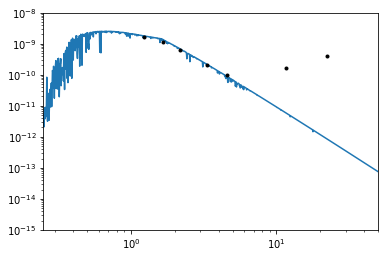

1516737448.97 78 4.91406410168
AWI0005ypo J052556.05-021601.5
W2 significantly low. Refitting with W2 included
[  5.86428767e-11   6.51597378e-11   5.61566188e-11   1.63829881e-11
   1.23568035e-11   1.25027671e-12   1.90479121e-13]
[  6.37661756e-11   5.93523541e-11   4.88705047e-11   2.07893534e-11
   1.11789619e-11   1.35242780e-12   2.13467635e-13]
2050.0 3.5 2.58389079222e-10


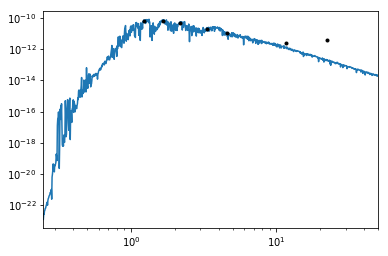

1516737459.49 79 4.98499999771
AWI0005wex J052617.32+055817.1
W2 significantly low. Refitting with W2 included
[  2.81418161e-11   2.39505882e-11   1.63545201e-11   4.10326882e-12
   3.00706624e-12   2.45212722e-13   3.79808109e-14]
[  2.69915128e-11   2.00481731e-11   1.38447041e-11   5.02664063e-12
   2.79150449e-12   2.77300686e-13   4.49540572e-14]
2500.0 2.5 1.0336953955e-10


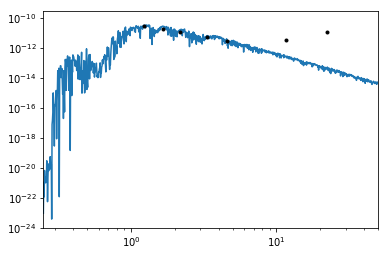

1516737469.48 80 5.04759999812
AWI0005ypv J052653.64-100458.1
W2 significantly low. Refitting with W2 included
[  1.31117180e-10   1.15218883e-10   6.75219979e-11   1.47855488e-11
   2.29482976e-11   7.01876135e-12   7.84624221e-13]
[  9.88404477e-11   9.37955602e-11   5.45244329e-11   2.69268354e-11
   2.50926084e-11   6.21524743e-12   1.06678370e-12]
1200.0 5.0 8.95872737722e-10


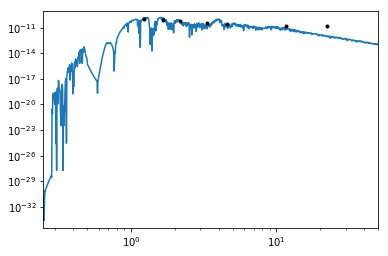

1516737481.5 81 5.13370370276
AWI0005n0p J052746.74+174407.4
W2 significantly low. Refitting with W2 included
[  5.79218017e-10   3.04291373e-10   1.60582611e-10   5.02681236e-11
   2.04481097e-11   1.87139636e-12   3.65749491e-12]
[  5.82609571e-10   3.01845203e-10   1.59801039e-10   5.07096475e-11
   2.12390609e-11   1.51914422e-12   2.26660589e-13]
7773.89587929 None 1.1219920433e-10


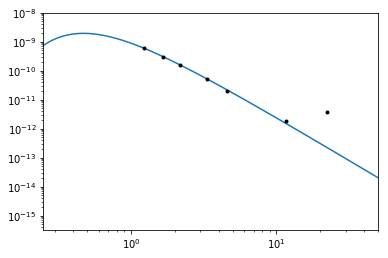

1516737483.33 82 5.09340243805
AWI0005wfn J052859.70+032148.6
W2 significantly low. Refitting with W2 included
[  5.09614836e-10   2.61872347e-10   1.40895952e-10   4.37011307e-11
   1.74362532e-11   1.98868401e-12   2.55378147e-12]
[  5.10318605e-10   2.63430433e-10   1.39148165e-10   4.40449187e-11
   1.84261273e-11   1.31560582e-12   1.96187519e-13]
7879.7139858 None 1.03651998294e-10


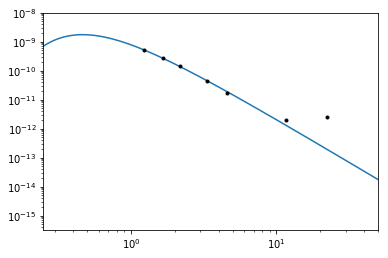

1516737484.89 83 5.05077108418
AWI0005wfv J052945.11+021539.6
W2 significantly low. Refitting with W2 included
[  1.88267663e-10   2.06034427e-10   1.79871111e-10   5.12452459e-11
   4.16357705e-11   4.05850989e-12   6.06063101e-13]
[  1.76868640e-10   1.66455601e-10   1.42464707e-10   6.19015393e-11
   3.40927427e-11   4.29907038e-12   6.84214864e-13]
2000.0 3.0 4.68386519325e-10


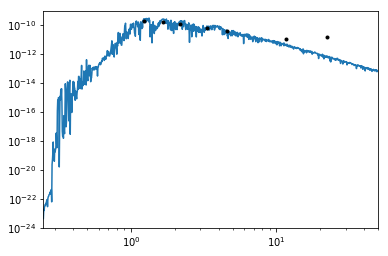

1516737509.89 84 5.28830952304
AWI0005wg8 J053020.90+004432.8
W2 significantly low. Refitting with W2 included
[  1.61789969e-09   2.15186813e-09   1.13093404e-09   2.76076501e-10
   1.03739098e-10   9.61263538e-12   1.52301333e-12]
[  1.57480468e-09   1.78843959e-09   1.08164102e-09   3.16867217e-10
   1.35343624e-10   1.12447658e-11   1.67945498e-12]
3400.0 2.5 5.14745214251e-10


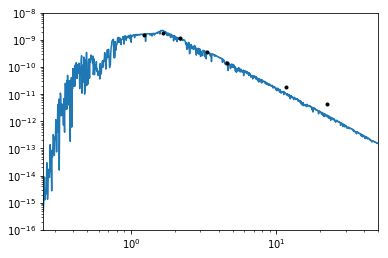

1516737535.09 85 5.52252941132
AWI0005yqi J053047.99-073132.4
W2 significantly low. Refitting with W2 included
[  5.11245362e-11   5.59491436e-11   4.88444323e-11   1.39157696e-11
   1.13062935e-11   1.10209811e-12   1.64577891e-13]
[  4.80291041e-11   4.52014185e-11   3.86866335e-11   1.68095117e-11
   9.25796619e-12   1.16742289e-12   1.85800190e-13]
2000.0 3.0 2.44079447644e-10


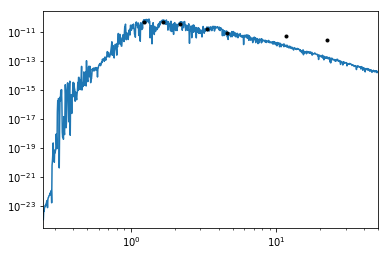

1516737544.78 86 5.57095348835
AWI0005wgp J053224.00-050523.4
W2 significantly low. Refitting with W2 included
[  2.08174301e-10   2.18369096e-10   1.81306260e-10   5.50560391e-11
   3.64601111e-11   3.92842070e-12   4.48765256e-13]
[  1.88713174e-10   1.78094208e-10   1.44363922e-10   6.16386092e-11
   3.12473594e-11   3.95481286e-12   6.11144471e-13]
2000.0 4.0 4.52355711639e-10


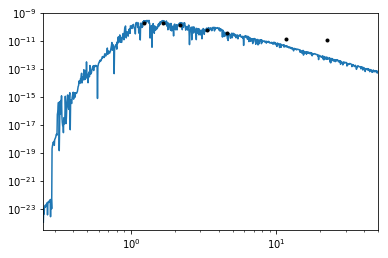

1516737565.65 87 5.74686206894
AWI0005wgs J053225.66-034313.6
W2 significantly low. Refitting with W2 included
[  6.11439696e-11   6.69141079e-11   5.84170088e-11   1.66429949e-11
   1.35221113e-11   1.31808831e-12   1.96832017e-13]
[  5.74418919e-11   5.40600338e-11   4.62684754e-11   2.01038552e-11
   1.10723509e-11   1.39621550e-12   2.22213482e-13]
2000.0 3.0 2.66927510837e-10


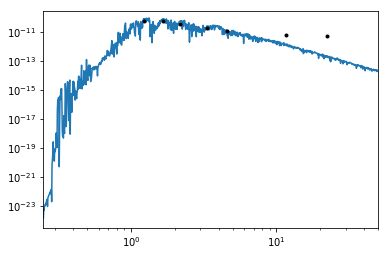

1516737573.74 88 5.77355681766
AWI0005wi7 J053431.70-035151.2
W2 significantly low. Refitting with W2 included
[  3.07275116e-10   2.59293395e-10   1.75514530e-10   5.45262011e-11
   2.88282491e-11   3.08473789e-12   3.32276405e-13]
[  2.53339259e-10   2.15253427e-10   1.45666253e-10   5.64096115e-11
   2.62248855e-11   3.01318790e-12   4.43041251e-13]
2300.0 5.0 3.76903540513e-10


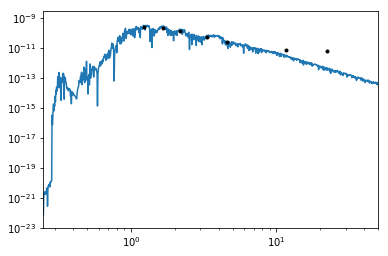

1516737599.8 89 6.00140449438
AWI00055xe J053523.12+594548.1
W2 significantly low. Refitting with W2 included
[  3.63782717e-09   1.81840091e-09   9.54329867e-10   2.96729585e-10
   1.18974302e-10   9.43986495e-12   2.47049359e-12]
[  3.63070072e-09   1.83008689e-09   9.52444647e-10   2.96540775e-10
   1.23108891e-10   8.68735268e-12   1.29092930e-12]
8661.00775029 None 2.53130007746e-10


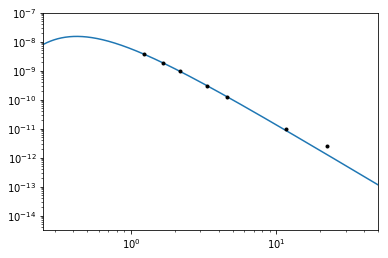

1516737602.01 90 5.95924444464
AWI0005wj7 J053525.11-064756.5
W2 significantly low. Refitting with W2 included
[  1.17296791e-10   1.38851378e-10   1.24185765e-10   3.90538615e-11
   2.83124209e-11   3.08018647e-12   4.71517965e-13]
[  1.05550729e-10   1.11868758e-10   9.82466364e-11   4.54476937e-11
   2.48011798e-11   3.19142730e-12   5.16895683e-13]
1900.0 3.5 4.16015572248e-10


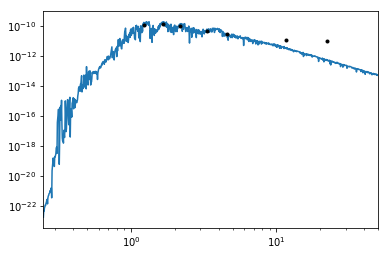

1516737620.21 91 6.09387912069
AWI0005wjy J053552.02-061001.6
W2 significantly low. Refitting with W2 included
[  4.37172002e-10   6.63462533e-10   7.59867772e-10   5.12071010e-10
   3.76307795e-10   5.41680519e-11   5.03192839e-12]
[  4.49394182e-10   5.80062811e-10   6.80274041e-10   4.71496048e-10
   2.87632893e-10   5.26200388e-11   8.98191857e-12]
1500.0 2.5 2.00767167342e-09


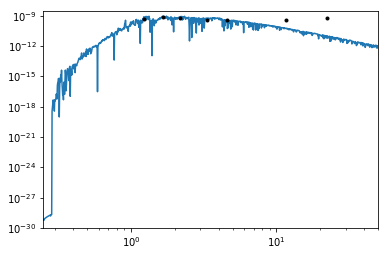

1516737634.44 92 6.18221739064
AWI0005wku J053628.55+000445.6
W2 significantly low. Refitting with W2 included
[  2.28633787e-10   2.00911350e-10   1.17740559e-10   2.57820982e-11
   4.00157797e-11   1.22388690e-11   1.36817774e-12]
[  1.72351677e-10   1.63554724e-10   9.50762332e-11   4.69533005e-11
   4.37548922e-11   1.08377526e-11   1.86018947e-12]
1200.0 5.0 1.18300539648e-09


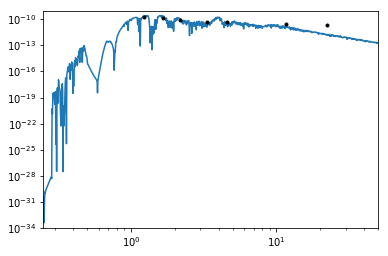

1516737658.44 93 6.37390322583
AWI00055xg J053707.15+603636.4
W2 significantly low. Refitting with W2 included
[  2.25134505e-09   1.09973903e-09   5.46636360e-10   1.70487552e-10
   6.68425742e-11   5.41209961e-12   1.84324783e-12]
[  2.24125664e-09   1.09098848e-09   5.55526942e-10   1.68784728e-10
   6.92751347e-11   4.80342722e-12   7.10008021e-13]
10187.538932 None 1.72597853841e-10


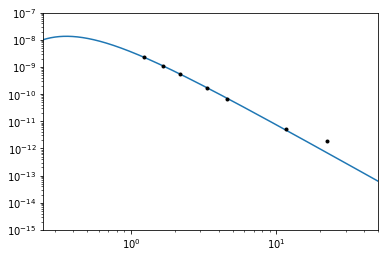

1516737660.26 94 6.32535106324
AWI0005wmu J053805.25-011521.6
W2 significantly low. Refitting with W2 included
[  1.03922648e-09   1.40111656e-09   1.58014117e-09   6.56429446e-10
   5.27838518e-10   5.93199916e-11   9.97452713e-12]
[  1.01504503e-09   1.15062257e-09   1.28156832e-09   7.72210889e-10
   4.66762991e-10   6.34759235e-11   1.06666238e-11]
1800.0 2.5 2.21218591847e-09


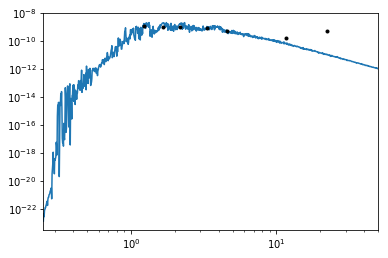

1516737683.53 95 6.50377894703
AWI0005wnn J053827.67-065453.6
W2 significantly low. Refitting with W2 included
[  1.06307505e-10   1.18121237e-10   1.01800429e-10   2.96989965e-11
   2.24003498e-11   2.26649519e-12   3.45299570e-13]
[  1.15594995e-10   1.07593642e-10   8.85921994e-11   3.76868329e-11
   2.02651646e-11   2.45167416e-12   3.86973030e-13]
2050.0 3.5 3.47895237822e-10


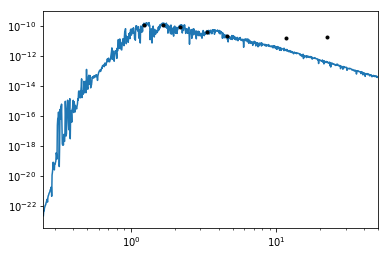

1516737702.03 96 6.62876041482
AWI0005wnz J053839.81-025646.2
W2 significantly low. Refitting with W2 included
[  9.83927389e-11   1.21206835e-10   7.96065376e-11   1.57159595e-11
   2.02560110e-11   4.86915867e-12   4.93475007e-13]
[  8.46716757e-11   1.02373071e-10   6.73278286e-11   3.01848323e-11
   2.22612353e-11   4.41226790e-12   6.74962777e-13]
1400.0 5.5 6.61375413825e-10


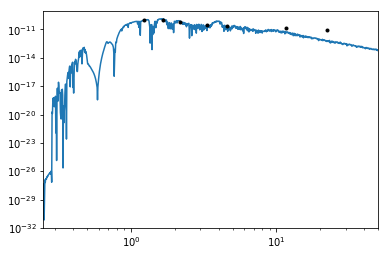

1516737715.66 97 6.70093814368
AWI0005yrn J053844.06-111411.1
W2 significantly low. Refitting with W2 included
[  3.78373181e-10   3.29597879e-10   2.46607358e-10   6.61756470e-11
   5.06537054e-11   4.35924445e-12   6.66242691e-13]
[  3.63995028e-10   2.74121455e-10   2.04716055e-10   7.97161036e-11
   4.49269106e-11   4.83080125e-12   7.86026376e-13]
2300.0 2.5 4.51571676695e-10


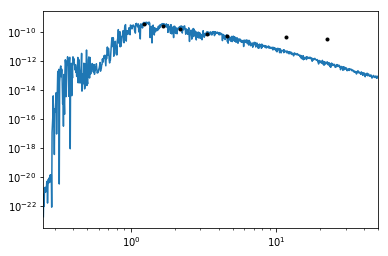

1516737734.86 98 6.82843877345
AWI0005wox J053926.39-021503.3
W2 significantly low. Refitting with W2 included
[  6.02395489e-11   8.12167811e-11   9.15940781e-11   3.80504293e-11
   3.05965589e-11   3.43852818e-12   5.78181009e-13]
[  5.88378529e-11   6.66967072e-11   7.42870768e-11   4.47617882e-11
   2.70562698e-11   3.67942991e-12   6.18298915e-13]
1800.0 2.5 5.32607621489e-10


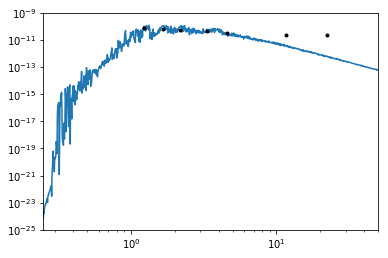

1516737754.19 99 6.95474747455
AWI0005wpr J054006.72-061618.9
W2 significantly low. Refitting with W2 included
[  1.97049346e-10   2.15644834e-10   1.88261139e-10   5.36355633e-11
   4.35778572e-11   4.24781773e-12   6.34332712e-13]
[  1.85118619e-10   1.74219868e-10   1.49109926e-10   6.47889160e-11
   3.56829874e-11   4.49959909e-12   7.16129839e-13]
2000.0 3.0 4.791858881e-10


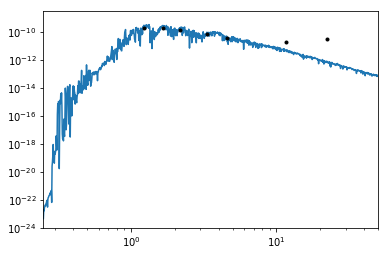

1516737766.84 100 7.01162999868
AWI0005yrp J054011.76-094211.1
W2 significantly low. Refitting with W2 included
[  3.09646577e-10   4.69926943e-10   5.38210255e-10   3.62697142e-10
   2.66536787e-10   3.83669398e-11   3.56408781e-12]
[  3.18303481e-10   4.10855369e-10   4.81834443e-10   3.33958114e-10
   2.03728831e-10   3.72704904e-11   6.36184460e-12]
1500.0 2.5 1.68966132296e-09


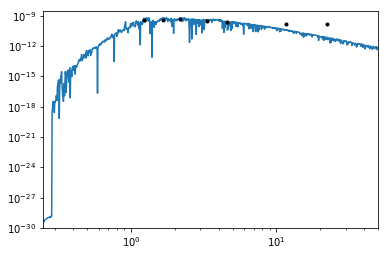

1516737781.07 101 7.08311881169
AWI0005wsf J054214.29-075835.1
W2 significantly low. Refitting with W2 included
[  7.17902999e-11   1.08950651e-10   1.24781859e-10   8.40898576e-11
   6.17954703e-11   8.89521898e-12   8.26319267e-13]
[  7.37973679e-11   9.52551467e-11   1.11711357e-10   7.74268309e-11
   4.72337011e-11   8.64101166e-12   1.47496780e-12]
1500.0 2.5 8.1357839088e-10


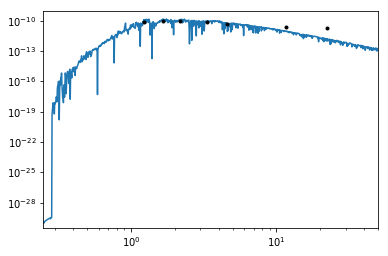

1516737788.78 102 7.08928431249
AWI0005wsk J054227.76-100151.2
W2 significantly low. Refitting with W2 included
[  2.79889688e-10   4.24767187e-10   4.86488506e-10   3.27842119e-10
   2.40922728e-10   3.46798951e-11   3.22158067e-12]
[  2.87714668e-10   3.71372363e-10   4.35530383e-10   3.01864899e-10
   1.84150587e-10   3.36888140e-11   5.75047437e-12]
1500.0 2.5 1.60642321107e-09


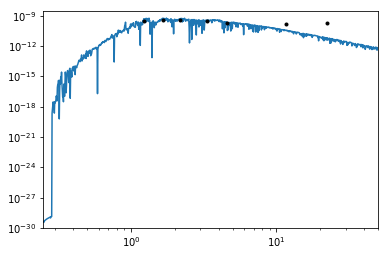

1516737796.94 103 7.0997378641
AWI0005e72 J054259.80+445105.2
W2 significantly low. Refitting with W2 included
[  5.09145679e-09   2.58517317e-09   1.31249759e-09   4.12717434e-10
   1.62425109e-10   1.27223044e-11   2.61808493e-12]
[  5.08681692e-09   2.54830035e-09   1.32113583e-09   4.09568482e-10
   1.69692350e-10   1.19379058e-11   1.77231867e-12]
8892.72054677 None 2.92559847518e-10


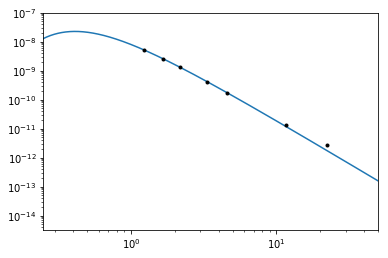

1516737798.81 104 7.04935576824
AWI0003lz9 J054330.38+251724.4
W2 significantly low. Refitting with W2 included
[  2.88267031e-09   1.86792329e-09   9.41414016e-10   2.84755961e-10
   1.01317823e-10   8.00360877e-12   1.17032663e-12]
[  2.84885326e-09   1.77467020e-09   9.55710887e-10   2.88085030e-10
   1.15154572e-10   8.71753699e-12   1.21063088e-12]
5800.0 2.5 3.33206917393e-10


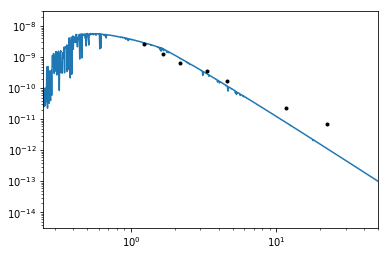

1516737826.7 105 7.24788571312
AWI00055xr J054733.26+521144.5
W2 significantly low. Refitting with W2 included
[  9.04182375e-10   7.88533410e-10   4.65952581e-10   1.41818826e-10
   6.34960796e-11   4.98938382e-12   7.77478072e-13]
[  8.87015364e-10   7.33126166e-10   4.55813932e-10   1.53172836e-10
   6.88877891e-11   5.67093750e-12   8.38441585e-13]
3600.0 5.5 3.49417409728e-10


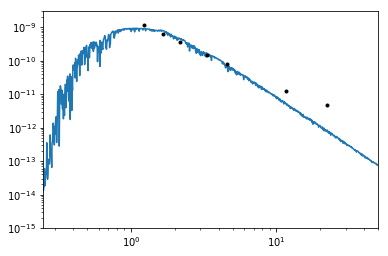

1516737838.57 106 7.29152830142
AWI0005zil J055417.57-383951.1
W2 significantly low. Refitting with W2 included
[  1.13189295e-10   9.94648009e-11   5.82895954e-11   1.27638945e-11
   1.98105362e-11   6.05907366e-12   6.77341160e-13]
[  8.53258180e-11   8.09707269e-11   4.70692105e-11   2.32450815e-11
   2.16616515e-11   5.36542563e-12   9.20920475e-13]
1200.0 5.0 8.32375328074e-10


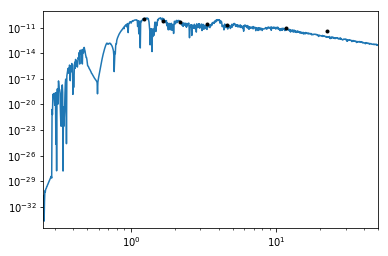

1516737856.23 107 7.38835513926
AWI0005wvr J055720.57-134921.9
W2 significantly low. Refitting with W2 included
[  1.68113713e-10   2.09974812e-10   2.16764832e-10   1.01386700e-10
   7.39935754e-11   9.81508389e-12   9.56897127e-13]
[  1.68491596e-10   1.74833971e-10   1.76780638e-10   9.92267703e-11
   5.61809849e-11   9.47767829e-12   1.57804692e-12]
1600.0 2.5 8.34580226455e-10


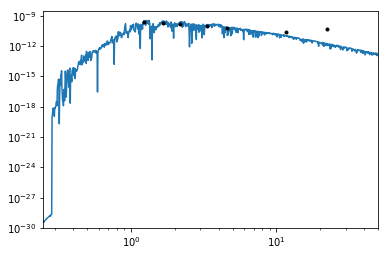

1516737888.32 108 7.61712036972
AWI0005ww1 J055804.52-141457.4
W2 significantly low. Refitting with W2 included
W2 significantly low. Refitting with W2 included
[  1.00056184e-10   6.18312461e-11   3.09620439e-11   9.34591413e-12
   3.70966601e-12   2.64566477e-13   3.86790722e-14]
[  9.90419180e-11   5.88662838e-11   3.15555312e-11   9.47697323e-12
   3.83733881e-12   2.88630858e-13   4.00461445e-14]
6100.0 2.5 5.8787973504e-11


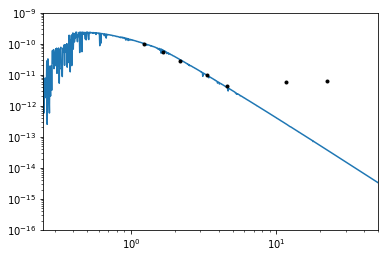

1516737938.59 109 8.00844036549
AWI0005wwi J055924.43-145421.8
W2 significantly low. Refitting with W2 included
[  7.28174642e-11   6.34307159e-11   4.74592899e-11   1.27354238e-11
   9.74824477e-12   8.38931357e-13   1.28217606e-13]
[  7.00504059e-11   5.27543448e-11   3.93973589e-11   1.53412684e-11
   8.64612998e-12   9.29681898e-13   1.51269832e-13]
2300.0 2.5 1.98099918459e-10


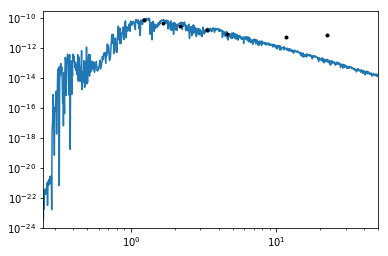

1516737955.94 110 8.09336363619
AWI0003lzu J060325.99+172444.3
W2 significantly low. Refitting with W2 included
[  1.10686643e-09   9.94395790e-10   6.33112517e-10   1.51207407e-10
   1.06975935e-10   8.61957974e-12   1.34889246e-12]
[  1.06088991e-09   8.16804079e-10   5.35213147e-10   1.86260572e-10
   1.02678951e-10   9.82186677e-12   1.59225268e-12]
2600.0 2.5 6.02301755214e-10


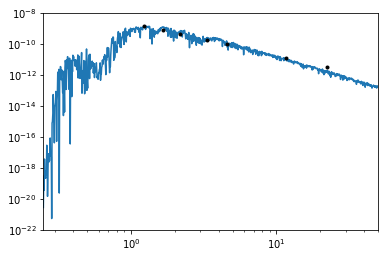

1516737974.43 111 8.18697297251
AWI0005ag4 J062612.83+473232.1
W2 significantly low. Refitting with W2 included
[  1.84705819e-10   2.80313904e-10   3.21045260e-10   2.16350761e-10
   1.58990601e-10   2.28860822e-11   2.12599720e-12]
[  1.89869708e-10   2.45077398e-10   2.87416791e-10   1.99207779e-10
   1.21525324e-10   2.22320444e-11   3.79487391e-12]
1500.0 2.5 1.30498887708e-09


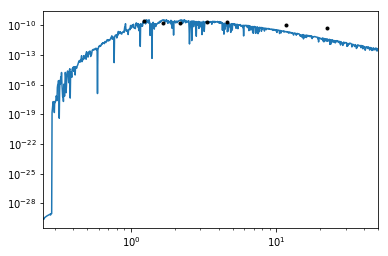

1516737990.1 112 8.25378571238
AWI0001a1v J064151.08+100144.6
W2 significantly low. Refitting with W2 included


KeyboardInterrupt: 

In [6]:
def fluxdrive_plot(spectname, binsize):
    spec_X, spec_S, spec_dict = import_spectrum(spectname, binsize)
    return spec_X, spec_S, spec_dict

def import_spectrum(spectname, binsize):
    spect_Xlist = []
    spect_Slist = []
    spect_dict = {}
    
    with open(spectname) as f:
        spectfilelist = f.readlines()
        
    testline = spectfilelist[0]
    test_res = [pos for pos, char in enumerate(testline) if char == '-']
    line_start = testline.index('1')
    
    flag1 = False
    flag2 = False
    
    flag1 = (test_res[0] < (7 + line_start))
    flag2 = (test_res[1] > (20 + line_start))
    
    #print flag1, flag2
    
    for line in spectfilelist:
        if (flag1 and flag2):
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag1:
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag2:
            line_use = line[:25] + ' ' + line[25:]
        else:
            line_use = line
            
        datavec = line_use.split()
        xstr = datavec[0]
        sstr = datavec[1]
        sstr1 = sstr.replace('D','e')
        #print datavec
        #print sstr1
        
        x = float(xstr)
        s = float(sstr1)
        
        spect_Xlist.append(x)
        spect_Slist.append((10.**(s-8.)))
        spect_dict[x] = s
        
    spect_X_binned = []
    spect_S_binned = []
    
    #ents_per_bin = binsize*20.
    
    spect_X = np.array(spect_Xlist)
    spect_S = np.array(spect_Slist)
    
    return spect_X, spect_S, spect_dict

def star_fitter_blackbody(centwavs, log10Teff, log10rdstar):
    centwavs_angstroms = centwavs * 1.e10 * u.AA
    centwavs_meters = centwavs * u.m
    
    #print log10Teff, log10rdstar
    
    Teff = 10.**(log10Teff)
    rdstar = 10.**(log10rdstar)
    
    #print Teff, rdstar
    
    #print centwavs_angstroms
    #print Teff
    
    #print blackbody_lambda(centwavs_angstroms[0], Teff*u.K)
    
    #flux_lam_temp = []
    #for wav in centwavs_angstroms:
    #    flux_lam_temp.append(blackbody_lambda(wav, Teff*u.K) * np.pi * u.sr)
    
    flux_lam_temp = blackbody_lambda(centwavs_angstroms, Teff*u.K) * np.pi * u.sr 
    
    #print flux_lam_temp
    
    flux_lam = flux_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg
    
    #print flux_lam 
    
    return flux_lam * (rdstar**2)


def get_chi2(mags, magerrs, result_mags):
    chis = np.zeros(mags.size)
    
    for i in range(mags.size):
        chis[i] = ((mags[i] - result_mags[i])**2)/magerrs[i]
        
    sumchis = np.sum(chis)
    
    return sumchis

def star_fitter_models(centwavs, mags, magerrs, guess):
    fit_results_dict = {model: None for model in btsettl_models_dict.keys()}
    fit_chi_dict = {model: None for model in btsettl_models_dict.keys()}
    
    Teff_guess = guess[0]
    difTeffguess = 7000. - Teff_guess
    
    mindifTeffguess = Teff_guess - difTeffguess
    
    keys_use = []
    
    for model in btsettl_models_dict.keys():
        Teff = model[0]
        logg = model[1]
        
        if Teff < mindifTeffguess:
            continue
        else:
            keys_use.append(model)
            def fit_rdstar(centwavs, log10rdstar):
                fitmagsfull = btsettl_models_dict[(Teff, logg)]
                fitmagsuse = fitmagsfull[0:centwavs.size]

                result_mags = fitmagsuse - 5.*log10rdstar
                return result_mags

        
            popt, pcov = curve_fit(fit_rdstar, centwavs, mags, sigma=magerrs)
        
            fit_mags = fit_rdstar(centwavs, popt[0])
            
            fit_results_dict[model] = popt[0]
            fit_chi_dict[model] = get_chi2(mags, magerrs, fit_mags)
    
    fit_chi_dict_use = {x: fit_chi_dict[x] for x in keys_use}
    fit_results_dict_use = {x: fit_results_dict[x] for x in keys_use}
    
    minchi = min(fit_chi_dict_use.values())
    
    best_model = fit_chi_dict_use.keys()[fit_chi_dict_use.values().index(minchi)]
    
    best_rdstar = 10.**(fit_results_dict_use[best_model])
    
    return best_model[0], best_model[1], best_rdstar

plotting_logx_vec = np.linspace(np.log10(0.25), np.log10(100.), 1001)
plotting_x_vec = np.zeros(1001)
    
for i in range(1001):
    plotting_x_vec[i] = 10.**(plotting_logx_vec[i])
    
plotting_xvec_angstroms = plotting_x_vec * 1.e4

btsettl_df = pd.read_csv('btsettl_combo_readin.csv',low_memory=False)
btsettl_data = btsettl_df.values

num_models = btsettl_data[:,0].size

btsettl_models_dict = {}

#print num_models

keylist = []

for i in range(num_models):
    #print btsettl_data[i,0]
    #print btsettl_data[i,1]
    #print btsettl_data[i,2:]
    keylist.append((float(btsettl_data[i,0]), float(btsettl_data[i,1])))

for i in range(num_models):
    btsettl_models_dict[keylist[i]] = btsettl_data[i,5:]
    
def get_star_fit_2mass(subj):
        #print subj.nuFnu.size
    #print subj.nuFnuerrs.size
    nuFnu_use = subj.nuFnu[:-4]
    nuFnu_err_use = subj.nuFnuerrs[:-4]
    cent_wavs_use = subj.centwavs_meters[:-4]
    
    mags_use = subj.mags[:-4]
    magerrs_use = subj.magerrs[:-4]
    
    #print nuFnu_use
    #print nuFnu_err_use
    #print cent_wavs_use
    
    Teff_guess = 10000.
    rdstar_guess = 1.e-10
    
    logTeff_guess = np.log10(Teff_guess)
    logrdstar_guess = np.log10(rdstar_guess)
    
    #print nuFnu_use
    
    popt, pcov = curve_fit(star_fitter_blackbody, cent_wavs_use, nuFnu_use, sigma = nuFnu_err_use, p0 = [logTeff_guess, logrdstar_guess])
    Teff_opt = 10.**(popt[0])
    rdstar_opt = 10.**(popt[1])
    
    nuFnu_star = blackbody_lambda(subj.centwavs_meters * 1.e10 * u.AA, Teff_opt * u.K) * np.pi * u.sr * (subj.centwavs_meters * 1.e10 * u.AA) * (rdstar_opt**2) * u.cm * u.cm * u.s / u.erg
    nuFnu_remain = subj.nuFnu - nuFnu_star
    

    use_models = False
        
    if Teff_opt < 7000.:
        use_models = True
    
    #Teff_opt = popt[0]
    #rdstar_opt = popt[1]
    
    if use_models:
        cent_wavs_fit = subj.centwavs_meters[:-4]
        mags_fit = subj.mags[:-4]
        magerrs_fit = subj.magerrs[:-4]
        Teff_use, logg_use, rdstar_use = star_fitter_models(cent_wavs_fit, mags_fit, magerrs_fit, [Teff_opt, rdstar_opt])
        subj.Teff = Teff_use
        subj.logg = logg_use
        subj.rdstar = rdstar_use
       
        model_mags = btsettl_models_dict[(Teff_use, logg_use)]
        
        model_mags_at_d = model_mags - 5.*np.log10(rdstar_use)
       
        fluxes_at_d = np.zeros(subj.mags.size)
        
        for i in range(subj.mags.size):
            fluxes_at_d[i] = filterzps_short[i] * 10.**(-0.4*model_mags_at_d[i]) * 10.**(-23.)
            
        subj.nuFnu_star = subj.centwavs_Hz * fluxes_at_d
        
        teffpull = '0'+str(int(Teff_use/100))
        loggpull = str(logg_use)
        
        spect_file = 'BTSettlstuff_use\\BT-Settl_M-0.0a+0.0\\lte'+teffpull+'.0-'+loggpull+'-0.0a+0.0.BT-Settl.spec.7'
        
        spec_X, spec_S, spec_dict = fluxdrive_plot(spect_file,1)
        
        #for i in range(spec_X.size):
        #    if spec_X[i] > 2500. and spec_X[i] < 50000.:
        #        print spec_X[i], spec_S[i]
        
        flux_spec_S = spec_X * spec_S * (rdstar_use**2)
        
        #spec_S_interp = np.interp(plotting_xvec_angstroms, spec_X, spec_S)
        
        spec_S_at_bands = np.interp(subj.centwavs_meters * 1.e10, spec_X, flux_spec_S)
        
        spec_S_adjust_flux = 220800. * rdstar_use* np.interp(220800., spec_X, spec_S)
        
        #print 2208. * spec_S_adjust_flux * rdstar_use
        #print spec_S_adjust_flux
        #print subj.nuFnu_star[-1]
        
        print spec_S_at_bands
        print subj.nuFnu_star
        
        #print plotting_xvec_angstroms
        #print spec_S_interp
        
        #for i in range(spec_S_interp.size):
        #    print plotting_xvec_angstroms[i], spec_S_interp[i]
        
        #print subj.nuFnu_star[-1]/spec_S_adjust_flux
        
        subj.nuFnu_star_plotting = np.interp(plotting_xvec_angstroms, spec_X, flux_spec_S)
        
    else:
        print "W2 significantly low. Refitting with W2 included"
        popt, pcov = curve_fit(star_fitter_blackbody, subj.centwavs_meters[:-2], subj.nuFnu[:-2], sigma = subj.nuFnuerrs[:-2], p0 = [popt[0], popt[1]])

        subj.Teff = Teff_opt
        subj.Teff_err = (pcov[0,0])**2
        subj.rdstar = rdstar_opt
        subj.rdstar_err = (pcov[1,1])**2
        
        #print subj.Teff, subj.rdstar
    
        subj.nuFnu_star = blackbody_lambda(subj.centwavs_meters * 1.e10 * u.AA, subj.Teff * u.K) * np.pi * u.sr * (subj.centwavs_meters * 1.e10 * u.AA) * (subj.rdstar**2) * u.cm * u.cm * u.s / u.erg
        
        print subj.nuFnu
        print subj.nuFnu_star
        
        #print subj.nuFnu
        #print subj.nuFnu_star
        
        subj.nuFnu_star_plotting = blackbody_lambda(plotting_xvec_angstroms * u.AA, subj.Teff*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * (subj.rdstar**2) * u.cm * u.cm * u.s / u.erg
    
    
    subj.nuFnu_disk = subj.nuFnu - subj.nuFnu_star
    
    subj.nuFnu_disk_errs = subj.nuFnuerrs
    
    subj.sig_disk = subj.nuFnu_disk[-4:] / subj.nuFnu_disk_errs[-4:]
    
    subj.num_excesses = subj.sig_disk[subj.sig_disk > 5].size
    
    if subj.num_excesses < 1:
        subj.num_excesses = subj.sig_disk[subj.sig_disk > 3].size
    
    return subj


def get_star_fit(subj):
    #print subj.nuFnu.size
    #print subj.nuFnuerrs.size
    nuFnu_use = subj.nuFnu[:-3]
    nuFnu_err_use = subj.nuFnuerrs[:-3]
    cent_wavs_use = subj.centwavs_meters[:-3]
    
    mags_use = subj.mags[:-3]
    magerrs_use = subj.magerrs[:-3]
    
    #print nuFnu_use
    #print nuFnu_err_use
    #print cent_wavs_use
    
    Teff_guess = 10000.
    rdstar_guess = 1.e-14
    
    use_w2 = False
    
    logTeff_guess = np.log10(Teff_guess)
    logrdstar_guess = np.log10(rdstar_guess)
    
    #print nuFnu_use
    
    popt, pcov = curve_fit(star_fitter_blackbody, cent_wavs_use, nuFnu_use, sigma = nuFnu_err_use, p0 = [logTeff_guess, logrdstar_guess])
    Teff_opt = 10.**(popt[0])
    rdstar_opt = 10.**(popt[1])

    #chi2test = 
    
    nuFnu_star = np.array(blackbody_lambda(subj.centwavs_meters * 1.e10 * u.AA, Teff_opt * u.K) * np.pi * u.sr * (subj.centwavs_meters * 1.e10 * u.AA) * (rdstar_opt**2) * u.cm * u.cm * u.s / u.erg)

    nuFnu_star_test = nuFnu_star[:-3]
    
    chi2test = np.sum(np.square(nuFnu_use - nuFnu_star_test)/nuFnu_err_use) / len(nuFnu_use)
    
    nuFnu_remain = subj.nuFnu - nuFnu_star
    
    if nuFnu_remain[-3] < subj.nuFnu[-3] - 5.*(subj.nuFnuerrs[-3]):
        use_w2=True

    use_models = False
        
    if Teff_opt < 6000.:
        use_models = True
    elif Teff_opt < 7000. and not use_w2:
        use_models = True
    elif Teff_opt > 6000. and Teff_opt < 7000. and use_w2:
        print "W2 significantly low. Refitting with W2 included"
        popt, pcov = curve_fit(star_fitter_blackbody, subj.centwavs_meters[:-2], subj.nuFnu[:-2], sigma = subj.nuFnuerrs[:-2], p0 = [popt[0], popt[1]])
        if (10.**(popt[0])) < 7000.:
            use_models = True
    
    #Teff_opt = popt[0]
    #rdstar_opt = popt[1]
    
    if use_models:
        if use_w2:
            cent_wavs_fit = subj.centwavs_meters[:-2]
            mags_fit = subj.mags[:-2]
            magerrs_fit = subj.magerrs[:-2]
            print "W2 significantly low. Refitting with W2 included"

        else:
            cent_wavs_fit = subj.centwavs_meters[:-3]
            mags_fit = subj.mags[:-3]
            magerrs_fit = subj.magerrs[:-3]
        Teff_use, logg_use, rdstar_use = star_fitter_models(cent_wavs_fit, mags_fit, magerrs_fit, [Teff_opt, rdstar_opt])
       
        model_mags = btsettl_models_dict[(Teff_use, logg_use)]
        
        model_mags_at_d = model_mags - 5.*np.log10(rdstar_use)

        chi2model = np.sum(np.array([((mags_fit[i] - model_mags_at_d[i])**2) for i in range(len(mags_fit))]) / magerrs_fit) / len(mags_fit)
        
        fluxes_at_d = np.zeros(subj.mags.size)
        
        for i in range(subj.mags.size):
            fluxes_at_d[i] = filterzps_short[i] * 10.**(-0.4*model_mags_at_d[i]) * 10.**(-23.)
            
        if not use_w2:
            cent_wavs_fit_short = subj.centwavs_meters[:-4]
            mags_fit_short = subj.mags[:-4]
            magerrs_fit_short = subj.magerrs[:-4]
            
            Teff_use_short, logg_use_short, rdstar_use_short = star_fitter_models(cent_wavs_fit_short, mags_fit_short, magerrs_fit_short, [Teff_opt, rdstar_opt])
            model_mags_short = btsettl_models_dict[(Teff_use_short, logg_use_short)]
            model_mags_short_at_d = model_mags_short - 5.*np.log10(rdstar_use_short)
            
            chi2short = np.sum(np.array([((mags_fit_short[i] - model_mags_short_at_d[i])**2) for i in range(len(model_mags_short))]) / magerrs_fit_short) / len(mags_fit_short)

            if chi2short < chi2model:
                print '2MASS only has better chi2'
                subj.Teff = Teff_use_short
                subj.logg = logg_use_short
                subj.rdstar = rdstar_use_short
            else:
                subj.Teff = Teff_use
                subj.logg = logg_use
                subj.rdstar = rdstar_use
        else:
            subj.Teff = Teff_use
            subj.logg = logg_use
            subj.rdstar = rdstar_use
            
        subj.nuFnu_star = subj.centwavs_Hz * fluxes_at_d
        
        teffpull = '0'+str(int(Teff_use/100))
        loggpull = str(logg_use)
        
        spect_file = 'BTSettlstuff_use\\BT-Settl_M-0.0a+0.0\\lte'+teffpull+'.0-'+loggpull+'-0.0a+0.0.BT-Settl.spec.7'
        
        spec_X, spec_S, spec_dict = fluxdrive_plot(spect_file,1)
        
        #for i in range(spec_X.size):
        #    if spec_X[i] > 2500. and spec_X[i] < 50000.:
        #        print spec_X[i], spec_S[i]
        
        flux_spec_S = spec_X * spec_S * (rdstar_use**2)
        
        #spec_S_interp = np.interp(plotting_xvec_angstroms, spec_X, spec_S)
        
        spec_S_at_bands = np.interp(subj.centwavs_meters * 1.e10, spec_X, flux_spec_S)
        
        spec_S_adjust_flux = 220800. * rdstar_use* np.interp(220800., spec_X, spec_S)
        
        #print 2208. * spec_S_adjust_flux * rdstar_use
        #print spec_S_adjust_flux
        #print subj.nuFnu_star[-1]
        
        print spec_S_at_bands
        print subj.nuFnu_star
        
        #print plotting_xvec_angstroms
        #print spec_S_interp
        
        #for i in range(spec_S_interp.size):
        #    print plotting_xvec_angstroms[i], spec_S_interp[i]
        
        #print subj.nuFnu_star[-1]/spec_S_adjust_flux
        
        subj.nuFnu_star_plotting = np.interp(plotting_xvec_angstroms, spec_X, flux_spec_S)
        
    else:
        if use_w2:
            print "W2 significantly low. Refitting with W2 included"
            popt, pcov = curve_fit(star_fitter_blackbody, subj.centwavs_meters[:-2], subj.nuFnu[:-2], sigma = subj.nuFnuerrs[:-2], p0 = [popt[0], popt[1]])

            subj.Teff = Teff_opt
            subj.Teff_err = (pcov[0,0])**2
            subj.rdstar = rdstar_opt
            subj.rdstar_err = (pcov[1,1])**2
        
            #print subj.Teff, subj.rdstar
            
        else:
            nuFnu_use = subj.nuFnu[:-4]
            nuFnu_err_use = subj.nuFnuerrs[:-4]
            cent_wavs_use = subj.centwavs_meters[:-4]

            logTeff_guess = np.log10(Teff_opt)
            logrdstar_guess = np.log10(rdstar_opt)
    
            #print nuFnu_use
    
            popt, pcov = curve_fit(star_fitter_blackbody, cent_wavs_use, nuFnu_use, sigma = nuFnu_err_use, p0 = [logTeff_guess, logrdstar_guess])
            Teff_opt_short = 10.**(popt[0])
            rdstar_opt_short = 10.**(popt[1])

            #chi2test = 
    
            nuFnu_star = np.array(blackbody_lambda(subj.centwavs_meters * 1.e10 * u.AA, Teff_opt_short * u.K) * np.pi * u.sr * (subj.centwavs_meters * 1.e10 * u.AA) * (rdstar_opt_short**2) * u.cm * u.cm * u.s / u.erg)

            nuFnu_star_test_short = nuFnu_star[:-4]
    
            chi2testshort = np.sum(np.square(nuFnu_use - nuFnu_star_test)/nuFnu_err_use) / len(nuFnu_use)

            if chi2testshort < chi2test:
                print "2MASS only has better chi2"
                subj.Teff = Teff_opt_short
                subj.rdstar = rdstar_opt_short
            else:
                subj.Teff = Teff_opt
                subj.rdstar = rdstar_opt_short
                
    
        subj.nuFnu_star = blackbody_lambda(subj.centwavs_meters * 1.e10 * u.AA, subj.Teff * u.K) * np.pi * u.sr * (subj.centwavs_meters * 1.e10 * u.AA) * (subj.rdstar**2) * u.cm * u.cm * u.s / u.erg
        
        print subj.nuFnu
        print subj.nuFnu_star
       
        #print subj.nuFnu
        #print subj.nuFnu_star
        
        subj.nuFnu_star_plotting = blackbody_lambda(plotting_xvec_angstroms * u.AA, subj.Teff*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * (subj.rdstar**2) * u.cm * u.cm * u.s / u.erg
    
    #test_subj = get_star_fit_2mass(subj)
    
    subj.nuFnu_disk = subj.nuFnu - subj.nuFnu_star
    
    subj.nuFnu_disk_errs = subj.nuFnuerrs
    
    subj.sig_disk = subj.nuFnu_disk[-4:] / subj.nuFnu_disk_errs[-4:]
    
    subj.num_excesses = subj.sig_disk[subj.sig_disk > 5].size
    
    if subj.num_excesses < 1:
        subj.num_excesses = subj.sig_disk[subj.sig_disk > 3].size
    
    return subj

start_time = time.time()
subjs_with_star_fits = []

print start_time

f1 = open('has_w3_excess.csv','w')
f2 = open('has_no_excess.csv','w')
f3 = open('has_w4_excess.csv','w')

for subj in raw_subjs:
    print subj.zooniverse_id, subj.wiseid
    subjs_with_star_fits.append(get_star_fit(subj))
    print subj.Teff, subj.logg, subj.rdstar

    if subj.num_excesses > 1:
        f1.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    elif subj.num_excesses < 1:
        f2.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    else:
        f3.write(subj.zooniverse_id+','+subj.wiseid+'\n')
        
    plt.errorbar(subj.centwavs_microns, subj.nuFnu, yerr=subj.nuFnuerrs, fmt='k.')
    plt.plot(plotting_x_vec, subj.nuFnu_star_plotting)
    
    ymin = float(np.floor((np.log10(min(subj.nuFnu_star_plotting))-0.5)*2.))/2.
    ymax = float(np.ceil(2.*(np.log10(max(subj.nuFnu_star_plotting))+0.5)))/2.

    
    #ymin = min(subj.nuFnu_star_plotting)
    #ymax = max(subj.nuFnu_star_flotting)
    
    plt.xscale("log", nonposx='clip')
    plt.yscale("log", nonposy='clip')
    plt.xlim([0.25, 50.])
    plt.ylim([10.**ymin, 10.**ymax])
    plt.show()
    
    print time.time(), len(subjs_with_star_fits), (time.time() - start_time)/len(subjs_with_star_fits)
    
star_fit_end_time = time.time()

f1.close()
f2.close()
f3.close()
    
print "Star fits done"
print "Time elapsed:", star_fit_end_time - start_time

In [6]:
test = 9.16338e0
test1 = 9.15878e0

testsub = test - 8.
testsub1 = test1 - 8.

testexp = 10.**(testsub)
testexp1 = 10.**(testsub1)

print test
print testsub
print testexp
print 280000.*testexp
print 280000.*testexp*2.65882969187e-10

print test1
print testsub1
print testexp1
print 280800.*testexp1
print 280800.*testexp1*2.65882969187e-10

9.16338
1.16338
14.5673313888
4078852.78885
0.00108449749038
9.15878
1.15878
14.41385006
4047409.09684
0.00107613714818


In [35]:
def plot_subj(subj):
    plt.figure()
    
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
    plt.rcParams.update(params)
        
    plt.gcf().subplots_adjust(left = 0.18)
    plt.gcf().subplots_adjust(right=0.95)
    plt.gcf().subplots_adjust(top=0.95)
    plt.gcf().subplots_adjust(bottom=0.16)
    
    #ax = plt.subplot
    
    plt.errorbar(subj.centwavs_microns, subj.nuFnu, yerr=subj.nuFnuerrs, fmt='k.')
        
    #plt.plot(subj.centwavs_microns, subj.nuFnu_star, 'r.')
        
    #print subj.nuFnu
    #print subj.nuFnu_star
    

    plt.xscale('log', nonposx='clip')
    plt.yscale('log', nonposy='clip')
    
    min_nuFnu_logs = min(np.log10(subj.nuFnu))
    max_nuFnu_logs = max(np.log10(subj.nuFnu_star_plotting))

    ymin = float(np.floor((min_nuFnu_logs-1.5)*2.))/2.
    ymax = float(np.ceil(2.*(max_nuFnu_logs+0.5)))/2.

    if subj.good_disk_fit:
        plt.plot(plotting_x_vec, subj.nuFnu_star_plotting, linestyle=':', label='Stellar fit')
        plt.plot(plotting_x_vec, subj.nuFnu_disk_plotting, linestyle='--', label='Disk blackbody')
        plt.plot(plotting_x_vec, subj.nuFnu_model_plotting, label='Combined model')
        plt.annotate(subj.wiseid+'\n'+'Tstar = %.0f K\nTdisk = %.0f K\nLir/Lstar = %.4e' % (subj.Teff, subj.Tdisk, subj.fir), xy=(0.55, 0.75), xycoords = 'axes fraction', fontsize=12)

    else:
        plt.plot(plotting_x_vec, subj.nuFnu_model_plotting)
        plt.annotate(subj.wiseid+'\n'+'Tstar = %.0f K\nNo good disk fit' % (subj.Teff), xy=(0.55, 0.75), xycoords = 'axes fraction', fontsize=12)
        
    plt.legend(loc='lower left',fontsize=12)
    
    
    plt.xlim([0.25, 100.])
    plt.ylim([10.**(ymin), 10.**(ymax)])
    
    plt.xlabel(r'$\mathrm{Wavelength(\mu m)}$', fontsize=20)
    plt.ylabel(r'$\mathrm{\nu F_{\nu} (erg\,s^{-1}\,cm^{-2})}$', fontsize=20)
    
    #if len(subjs_with_star_fits) < 2:
    plt.savefig(subj.zooniverse_id+'_modelfit.pdf')
    
    plt.close()
    
    #plt.show()
    return

In [36]:
wien_lamFlam_x = 3.90269

wien_lamFlam_factor = (h*c)/(wien_lamFlam_x*k)

def disk_fitter(centwavs, logTdisk, logxdisk):
    centwavs_angstroms = centwavs * 1.e10 * u.AA
    centwavs_meters = centwavs * u.m
    
    Tdisk = 10.**logTdisk
    xdisk = 10.**logxdisk
    
    #print centwavs_angstroms
    #print Teff
    
    #print blackbody_lambda(centwavs_angstroms[0], Teff*u.K)
    
    #flux_lam_temp = []
    #for wav in centwavs_angstroms:
    #    flux_lam_temp.append(blackbody_lambda(wav, Teff*u.K) * np.pi * u.sr)
    
    flux_lam_temp = blackbody_lambda(centwavs_angstroms, Tdisk*u.K) * np.pi * u.sr 
    
    #print flux_lam_temp
    
    flux_lam = flux_lam_temp * centwavs_angstroms * u.cm * u.cm * u.s / u.erg
    
    #print flux_lam 
    
    #print Tdisk, xdisk, max(flux_lam)
    
    #print xdisk
    
    return flux_lam * xdisk
    
def get_objective_function_value(subj, logTdiskguess, logxdiskguess):
    #Tdiskguess, xdiskguess = params
    #logTdiskguess = np.log10(Tdiskguess)
    #logxdiskguess = np.log10(xdiskguess)
    flux_lam_fit_disk = disk_fitter(subj.centwavs_meters, logTdiskguess, logxdiskguess)
    
    flux_lam_fit = flux_lam_fit_disk + subj.nuFnu_star
    
    flux_lam = subj.nuFnu
    flux_lam_errs = subj.nuFnuerrs
    
    #print min(flux_lam_errs)
    
    chiconts = np.zeros(flux_lam.size)
    
    for i in range(flux_lam.size):
        chiconts[i] = ((flux_lam[i] - flux_lam_fit[i])/flux_lam_errs[i])**2
        
    chisum = np.sum(chiconts)
    
    return chisum
        

def get_disk_fit(subj):
    subj.good_disk_fit = False
    nuFnu_use = subj.nuFnu_disk[-4:]
    nuFnu_err_use = subj.nuFnu_disk_errs[-4:]
    cent_wavs_use = subj.centwavs_meters[-4:]
    
    #print nuFnu_use
    #print nuFnu_err_use
    #print cent_wavs_use
    
    #Tstar = subj.Teff
    #rdstar = subj.rdstar
    
    #sig_nuFnu_use = nuFnu_use / nuFnu_err_use
    #print sig_nuFnu_use
    #print sig_nuFnu_use[sig_nuFnu_use > 5.]
    #print sig_nuFnu_use[sig_nuFnu_use > 5.].size
    
    if subj.num_excesses < 1:
        print "No significant excess"
        subj.nuFnu_model_plotting = subj.nuFnu_star_plotting
        return subj
    elif subj.num_excesses > 1:
        Tdiskguess = 200.
        xdiskguess = 1.e-3 * ((subj.Teff/Tdiskguess)**4)*(subj.rdstar**2)
        guess = [np.log10(200.), np.log10(xdiskguess)]
        popt, pcov = curve_fit(disk_fitter, cent_wavs_use, nuFnu_use, p0 = guess, sigma = nuFnu_err_use)
        
        subj.Tdisk = 10.**(popt[0])
        subj.xdisk = 10.**(popt[1])
        subj.fir = ((subj.Tdisk/subj.Teff)**4)*(subj.xdisk/(subj.rdstar**2))
        
        print "Excesses:", subj.num_excesses
        nuFnu_disk_points = blackbody_lambda(subj.centwavs_meters * 1.e10 * u.AA, subj.Tdisk * u.K) * np.pi * u.sr * (subj.centwavs_meters * 1.e10 * u.AA) * subj.xdisk * u.cm * u.cm * u.s / u.erg
        print nuFnu_disk_points
        print subj.nuFnu_disk
        
        subj.good_disk_fit = True
        
        subj.nuFnu_disk_plotting = blackbody_lambda(plotting_xvec_angstroms * u.AA, subj.Tdisk*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * subj.xdisk * u.cm * u.cm * u.s / u.erg
        subj.nuFnu_model_plotting = subj.nuFnu_star_plotting  + subj.nuFnu_disk_plotting
        
        return subj
    
    else:
        print "Excesses:", subj.num_excesses
        #while not subj.good_disk_fit:
        #lambda_max_star = (2.8977729e-3 / Tstar)

        #peak_flux_star = blackbody_lambda((lambda_max_star*1.e10*u.AA), (Tstar*u.K))

        #lambda_max_disk = (2.8977729e-3 / 1.)
    
        #test_min_peak_flux_disk = blackbody_lambda((lambda_max_disk*1.e10*u.AA), (1.*u.K))
        #test_max_peak_flux_disk = blackbody_lambda(((2.8977729e-3/500.)*1.e10*u.AA), (500.*u.K))
    
        #test_min_peak_flux_disk_at_star = blackbody_lambda((lambda_max_star*1.e10*u.AA), (1.*u.K))
        #test_max_peak_flux_disk_at_star = blackbody_lambda(((lambda_max_star*1.e10*u.AA), (500.*u.K)))
    
        #test_min_peak_flux_star_at_disk = blackbody_lambda((lambda_max_disk*1.e10*u.AA), (Tstar*u.K))
        #test_max_peak_flux_star_at_disk = blackbody_lambda(((2.8977729e-3/500.)*1.e10*u.AA), (Tstar*u.K))
    
        #xdiskmax = 0.1 * rdstar * ((lambda_max_star * peak_flux_star) - (lambda_max_disk * test_min_peak_flux_star_at_disk))/((lambda_max_disk * test_min_peak_flux_disk) - (lambda_max_star * test_min_peak_flux_disk_at_star))
        #xdiskmin = 0.1* float((peak_flux_star / test_max_peak_flux_disk)) * (lambda_max_star/(2.8977729e-3/500.)) * rdstar
    
        #Tdiskmax = 0.1*Tstar
        #xdiskmax = 2.e14*rdstar
        #xdiskmin = float(1.e9*rdstar)
    
        #print xdiskmin, xdiskmax
    
        Tdiskvals = np.linspace(25., 300., 12)
        #xdiskvals = np.linspace(xdiskmin, 1.e11*rdstar, 51)
    
        #valgrid = np.zeros(51*51).reshape(51,51)
        #reschi = np.zeros(51*51).reshape(51,51)
    
        val_chi_dict = {}
        
        xdiskvals_dict = {}
        
        Tdiskval_minchis_dict = {}
    
        for i in range(12):
            Tdiskval = Tdiskvals[i]
        
            xdiskmax = (subj.rdstar**2) * 1.e-2 * ((subj.Teff/Tdiskval)**4)
            xdiskmin = (subj.rdstar**2) * 1.e-9 * ((subj.Teff/Tdiskval)**4)
         
            xdiskvals = np.linspace(xdiskmin, xdiskmax, 51)
            
            xdiskvals_dict[Tdiskval] = xdiskvals
            
            for j in range(51):
                val_chi_dict[(Tdiskvals[i], xdiskvals[j])] = get_objective_function_value(subj, np.log10(Tdiskvals[i]), np.log10(xdiskvals[j]))
                #valgrid[i,j] = (Tdiskvals[i], xdiskvals[j])
                #reschi[i,j] = get_objective_function_value(subj, Tdiskvals[i], xdiskvals[j])
    
        minchi = np.inf
        minchi_vals = None
   
        possible_minchi_vals = []
    
        minchi_chis_by_temperature = {Temp: np.inf for Temp in Tdiskvals}
        minchi_vals_by_temperature = {Temp: None for Temp in Tdiskvals}
    
        for key in val_chi_dict.keys():
            keytemp = key[0]
            
            if val_chi_dict[key] < minchi_chis_by_temperature[keytemp]:
                minchi_chis_by_temperature[keytemp] = val_chi_dict[key]
                minchi_vals_by_temperature[keytemp] = key
            
            if val_chi_dict[key] < minchi:
                minchi = val_chi_dict[key]
                minchi_vals = key

        for key in val_chi_dict.keys():
            local_min = True
            if (val_chi_dict[key] - minchi)/(minchi) < 1.:
                Tdiskval = key[0]
                xdiskval = key[1]
                xdiskindex = np.where(xdiskvals_dict[Tdiskval] == xdiskval)
                Tdiskindex = np.where(Tdiskvals==Tdiskval)
                
                if (Tdiskindex[0] > 0) and (Tdiskindex[0] < 11) and (xdiskindex[0] > 0) and (xdiskindex[0] < 50):
                    for i in range(Tdiskindex[0] - 1, Tdiskindex[0] + 2):
                        xdiskvals_surrounding = xdiskvals_dict[Tdiskvals[i]]
                        for j in range(xdiskindex[0] - 1, xdiskindex[0] + 2):
                            if (val_chi_dict[key] > val_chi_dict[(Tdiskvals[i], xdiskvals_surrounding[j])]):
                                local_min = False
                                
                if local_min:
                    possible_minchi_vals.append(key)
                
    #from pprint import pprint
    #pprint(val_chi_dict)
                
        print minchi_vals
        print len(possible_minchi_vals)
    
        possible_minchi_results_dict = {}
        possible_minchi_chi_dict = {}
    
        for possible_minchi_val in possible_minchi_vals:
            guess = np.array([np.log10(possible_minchi_val[0]), np.log10(possible_minchi_val[1])])
    
            #print nuFnu_use
            try:
                popt, pcov = curve_fit(disk_fitter, cent_wavs_use, nuFnu_use, guess, sigma = nuFnu_err_use)
            except RuntimeError:
                continue
            possible_minchi_results_dict[possible_minchi_val] = np.array(popt)
            possible_minchi_chi_dict[possible_minchi_val] = get_objective_function_value(subj, popt[0], popt[1])
    
        #final_minchi = np.inf
        #final_minchi_vals = None
        
        minchi_temp_results_dict = {}
        minchi_temp_chi_dict = {}
        
        for minchi_val_by_temp in minchi_vals_by_temperature.values():
            guess = np.array([np.log10(minchi_val_by_temp[0]), np.log10(minchi_val_by_temp[1])])
            
            try:
                popt, pcov = curve_fit(disk_fitter, cent_wavs_use, nuFnu_use, guess, sigma = nuFnu_err_use)
            except RuntimeError:
                continue
                
            minchi_temp_results_dict[minchi_val_by_temp] = np.array(popt)
            minchi_temp_chi_dict[minchi_val_by_temp] = get_objective_function_value(subj, popt[0], popt[1])
            
        sorted_chis = sorted(possible_minchi_chi_dict.values())
        
        print len(sorted_chis)
        
        sorted_minchi_keys = []
        
        for chi in sorted_chis:
            sorted_minchi_keys.append(possible_minchi_chi_dict.keys()[possible_minchi_chi_dict.values().index(chi)])
        
        sorted_results = [possible_minchi_results_dict[x] for x in sorted_minchi_keys]
        
        sorted_temp_chis = sorted(minchi_temp_chi_dict.values())
        
        print len(sorted_temp_chis)
        
        sorted_temp_minchi_keys = []
        
        for chi in sorted_temp_chis:
            sorted_temp_minchi_keys.append(minchi_temp_chi_dict.keys()[minchi_temp_chi_dict.values().index(chi)])
            
        sorted_temp_results = [minchi_temp_results_dict[x] for x in sorted_temp_minchi_keys]
        
        result_index = 0
        result_index_temp = 0
        while not subj.good_disk_fit:
            if result_index > (len(sorted_results)-1):
                print "Out of values; testing temperature results"
                
                result = sorted_temp_results[result_index_temp]
                
                print result
                print 10.**result
                test_Tdisk = 10.**(result[0])
                test_xdisk = 10.**(result[1])
                
                test_fir = ((test_Tdisk/subj.Teff)**4) * (test_xdisk/(subj.rdstar**2))
                
                peak_lambda_disk = wien_lamFlam_factor / test_Tdisk
                
                peak_lamFlam_disk = None
                
                if peak_lambda_disk < (100.*1.e-6):
                    peak_lamFlam_disk = blackbody_lambda(peak_lambda_disk * 1.e10 * u.AA, test_Tdisk * u.K) * np.pi * u.sr * (peak_lambda_disk * 1.e10 * u.AA) * test_xdisk * u.cm * u.cm * u.s / u.erg
                else:
                    peak_lamFlam_disk = blackbody_lambda(100. * 1.e4 * u.AA, test_Tdisk * u.K) * np.pi * u.sr * (100. * 1.e4 * u.AA) * test_xdisk * u.cm * u.cm * u.s / u.erg
    
                peak_lamFlam_star = None
        
                if np.argmax(subj.nuFnu_star_plotting) > 0:
                    peak_lamFlam_star = max(subj.nuFnu_star_plotting)
                else:
                    peak_lambda_star = wien_lamFlam_factor / subj.Teff
                    peak_lamFlam_star = blackbody_lambda(peak_lambda_star * 1.e10 * u.AA, subj.Teff * u.K) * np.pi * u.sr * (peak_lambda_star * 1.e10 * u.AA) * (subj.rdstar**2) * u.cm * u.cm * u.s / u.erg
        
                if (test_fir < 0.01) and (peak_lamFlam_disk < peak_lamFlam_star):
                    subj.Tdisk = test_Tdisk
                    subj.xdisk = test_xdisk
                    subj.fir = test_fir
                    subj.good_disk_fit = True
                    print "Good fit"
                else:
                    print "Fit fail--retrying"
              
                result_index_temp += 1
                
                if result_index_temp > (len(sorted_temp_results) - 1):
                    print "Out of trial values, giving up"
                    break

            else:
                #if (possible_minchi_chi_dict[key] < final_minchi): #and (peak_lamFlam_disk < peak_lamFlam_star):
                #    final_minchi = possible_minchi_chi_dict[key]
                #    final_minchi_vals = possible_minchi_results_dict[key]
                result = sorted_results[result_index]
                                      
                print result
                print 10.**result
                test_Tdisk = 10.**(result[0])
                #subj.Tdisk_err = (pcov[0,0])**2
                test_xdisk = 10.**(result[1])
                #subj.xdisk_err = (pcov[1,1])**2
    
                #print subj.Tdisk, subj.xdisk
                test_fir = ((test_Tdisk/subj.Teff)**4)*(test_xdisk/(subj.rdstar**2))
        
                peak_lambda_disk = wien_lamFlam_factor / test_Tdisk
         
                peak_lamFlam_disk = None
    
                if peak_lambda_disk < (100.*1.e-6):
                    peak_lamFlam_disk = blackbody_lambda(peak_lambda_disk * 1.e10 * u.AA, test_Tdisk * u.K) * np.pi * u.sr * (peak_lambda_disk * 1.e10 * u.AA) * test_xdisk * u.cm * u.cm * u.s / u.erg
                else:
                    peak_lamFlam_disk = blackbody_lambda(100. * 1.e4 * u.AA, test_Tdisk * u.K) * np.pi * u.sr * (100. * 1.e4 * u.AA) * test_xdisk * u.cm * u.cm * u.s / u.erg
        
                peak_lamFlam_star = None
        
                if np.argmax(subj.nuFnu_star_plotting) > 0:
                    peak_lamFlam_star = max(subj.nuFnu_star_plotting)
                else:
                    peak_lambda_star = wien_lamFlam_factor / subj.Teff
                    peak_lamFlam_star = blackbody_lambda(peak_lambda_star * 1.e10 * u.AA, subj.Teff * u.K) * np.pi * u.sr * (peak_lambda_star * 1.e10 * u.AA) * (subj.rdstar**2) * u.cm * u.cm * u.s / u.erg
        
                if (test_fir < 0.01) and (peak_lamFlam_disk < peak_lamFlam_star):
                    subj.Tdisk = test_Tdisk
                    subj.xdisk = test_xdisk
                    subj.fir = test_fir
                    subj.good_disk_fit = True
                    print "Good fit"
                else:
                    print "Fit fail--retrying"
            
                result_index += 1
            
        if subj.good_disk_fit:
            nuFnu_disk_points = blackbody_lambda(subj.centwavs_meters * 1.e10 * u.AA, subj.Tdisk * u.K) * np.pi * u.sr * (subj.centwavs_meters * 1.e10 * u.AA) * subj.xdisk * u.cm * u.cm * u.s / u.erg
            print nuFnu_disk_points
            print subj.nuFnu_disk
            #nuFnu_disk_points = blackbody_lambda(cent_wavs_use*1.e10 *u.AA, subj.Tdisk * u)
        
            subj.nuFnu_disk_plotting = blackbody_lambda(plotting_xvec_angstroms * u.AA, subj.Tdisk*u.K) * np.pi * u.sr * (plotting_xvec_angstroms * u.AA) * subj.xdisk * u.cm * u.cm * u.s / u.erg
            print np.interp(subj.centwavs_meters*1.e10, plotting_xvec_angstroms, subj.nuFnu_disk_plotting)
        
            subj.nuFnu_model_plotting = subj.nuFnu_star_plotting + subj.nuFnu_disk_plotting
            #subj.nuFnu_disk = subj.nuFnu - subj.nuFnu_star
    
            #subj.nuFnu_disk_errs = subj.nuFnuerrs
    
            return subj
    
        else:
            subj.nuFnu_model_plotting = subj.nuFnu_star_plotting
            return subj


#subj_test = subjs_with_star_fits[40]

subjs_with_disk_fits = []

plt.close("all")

disk_fit_start_time = time.time()

for subj in subjs_with_star_fits:
    print subj.zooniverse_id, subj.wiseid
    print subj.num_excesses
    subjs_with_disk_fits.append(get_disk_fit(subj))
    print subj.Tdisk, subj.xdisk
    
    plot_subj(subj)

    #if subj.num_excesses > 1:
    #    f1.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    #elif subj.num_excesses < 1:
    #    f2.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    #else:
    #    f3.write(subj.zooniverse_id+','+subj.wiseid+'\n')
    
    print len(subjs_with_disk_fits), len(subjs_with_star_fits), (time.time() - disk_fit_start_time)/len(subjs_with_disk_fits)
    
disk_fit_end_time = time.time()

#f1.close()
#f2.close()
#f3.close()
    
print "Disk fits done"
print "Time elapsed:", disk_fit_end_time - disk_fit_start_time



AWI00062h7 J002133.47-661816.6
1
Excesses: 1
(50.0, 2.6533171618780207e-13)
2


C:\Users\Steven Silverberg\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
C:\Users\Steven Silverberg\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


2
12
[  2.3112749  -16.87861917]
[  2.04774042e+02   1.32245477e-17]
Good fit
[  4.16752667e-31   2.83115343e-25   1.67466078e-21   3.05873057e-17
   2.56974293e-15   6.36767403e-13   9.01324745e-13]
[  4.47439542e-11  -3.04679088e-11  -1.73121904e-11   6.10134474e-12
  -2.03811522e-12   6.36945955e-13   9.01260695e-13]
[  4.21456633e-31   2.84152442e-25   1.67767585e-21   3.06059882e-17
   2.57010153e-15   6.36763090e-13   9.01322028e-13]
204.77404204 1.32245477187e-17
1 242 12.3209998608
AWI0000nfp J002155.14-672715.9
2
Excesses: 2
[  3.41209835e-18   8.54660716e-16   2.61735549e-14   9.15859394e-13
   3.53033780e-12   6.42559652e-12   2.23006855e-12]
[  4.64291427e-11  -1.89169403e-11  -2.65415689e-11   1.84266973e-12
   7.23782359e-13   6.63824270e-12   1.86998180e-12]
445.989468406 4.68962144553e-18
2 242 6.77499997616
AWI0000bs0 J003140.76-014737.3
2
Excesses: 2
[  1.33103563e-32   3.25857980e-26   4.52561465e-22   2.28032347e-17
   3.15816786e-15   1.75147300e-12   3.16566829e-1

21 242 5.71328570729
AWI0005yjp J022515.75+370707.9
2
Excesses: 2
[  6.78938123e-30   2.74433570e-24   1.14888821e-20   1.39127366e-16
   9.54645923e-15   1.70730606e-12   2.19056084e-12]
[  4.25921908e-11  -4.02808610e-11   9.84278476e-12   9.44909440e-13
  -3.23357340e-12   1.70785961e-12   2.19021326e-12]
212.315457127 2.8556901978e-17
22 242 5.4961363619
AWI0005yjq J023047.36+360701.7
1
Excesses: 1
(100.0, 1.1856755891065982e-15)
4
4
12
[  2.16816027 -15.86201662]
[  1.47285593e+02   1.37398939e-16]
Good fit
[  9.82877636e-40   2.00590407e-31   5.29589923e-26   8.84759484e-20
   6.87531742e-17   6.15708462e-13   2.62359564e-12]
[  1.41747956e-11   1.10728288e-11  -1.59764417e-11   4.25429137e-12
  -2.23213200e-12   6.15713300e-13   2.62359376e-12]
[  1.00535106e-39   2.02158508e-31   5.31599395e-26   8.86024409e-20
   6.87781157e-17   6.15716342e-13   2.62357519e-12]
147.28559308 1.37398938809e-16
23 242 5.88843478327
AWI0000b9g J023115.97-094845.9
2
Excesses: 2
[  1.41984824e-37  

40 242 7.17714999914
AWI0002d6a J033549.39+641324.7
1
Excesses: 1
(50.0, 3.1195984182294097e-13)
2
2
12
[  2.18995003 -16.33740326]
[  1.54863841e+02   4.59829409e-17]
Good fit
[  1.57804593e-38   1.19137128e-30   1.62229365e-25   1.23353946e-19
   6.50458970e-17   3.11619473e-13   1.09347570e-12]
[  1.15594669e-11  -2.69446894e-11   5.89746691e-12  -6.00436594e-14
  -3.27481161e-12   3.11636307e-13   1.09347006e-12]
[  1.61049375e-38   1.19967960e-30   1.62780422e-25   1.23509594e-19
   6.50664753e-17   3.11621936e-13   1.09346773e-12]
154.863841256 4.5982940917e-17
41 242 7.35114633746
AWI00062j7 J033709.08-294948.5
1
Excesses: 1
(50.0, 2.6430805749151384e-13)
2
2
12
[  2.33646195 -16.95713426]
[  2.17001108e+02   1.10373736e-17]
Good fit
[  8.58116737e-30   2.55830658e-24   8.74528587e-21   8.32269113e-17
   5.07160734e-15   7.49214028e-13   9.07701916e-13]
[  2.03124070e-11  -1.83559129e-11  -4.09893240e-12   4.65981637e-12
  -3.83029346e-12   7.49628641e-13   9.07550493e-13]
[  8.

60 242 6.25598333279
AWI0005yn4 J045013.22+034100.3
1
Excesses: 1
(50.0, 4.2671778604328502e-13)
2
2
12
[  2.23995989 -16.41918186]
[  1.73764033e+02   3.80906289e-17]
Good fit
[  4.67660217e-35   4.31391865e-28   1.44907073e-23   2.08655118e-18
   4.84733249e-16   6.18993504e-13   1.44416749e-12]
[  2.51903580e-11  -7.01996599e-11   2.38217022e-11  -1.24252139e-12
  -8.13084878e-12   6.19106909e-13   1.44413919e-12]
[  4.75184223e-35   4.33703320e-28   1.45287494e-23   2.08851677e-18
   4.84844124e-16   6.18993264e-13   1.44415917e-12]
173.76403311 3.80906288501e-17
61 242 6.35560655594
AWI0005zgy J045245.95-062129.5
1
Excesses: 1
(125.0, 2.4133022421967332e-16)
4
4
12
[  2.19655164 -16.19830942]
[  1.57235876e+02   6.33418269e-17]
Good fit
[  6.76209155e-38   3.81400542e-30   4.27715931e-25   2.58193810e-19
   1.21517262e-16   4.84609033e-13   1.60657372e-12]
[  3.06615556e-12  -1.56545650e-11   2.12937761e-12  -3.08196908e-14
  -3.39451758e-12   4.84625776e-13   1.60656287e-12]
[  6

82 242 5.26884146144
AWI0005wfn J052859.70+032148.6
2
Excesses: 2
[  3.51607601e-38   2.63086552e-30   3.56117216e-25   2.68868348e-19
   1.41283315e-16   6.73054862e-13   2.35763828e-12]
[ -7.03769126e-13  -1.55808641e-12   1.74778665e-12  -3.43788015e-13
  -9.89874111e-13   6.73078183e-13   2.35759395e-12]
154.93559065 9.89477084799e-17
83 242 5.21579518088
AWI0005wfv J052945.11+021539.6
2
Excesses: 2
[  6.56670209e-32   1.54019514e-25   2.07890327e-21   1.01256293e-16
   1.37912692e-14   7.44516107e-12   1.33465928e-11]
[  9.18666697e-12   1.84653930e-12  -1.96363861e-11   2.02668986e-12
   2.13599202e-12   7.44357055e-12   1.33498581e-11]
188.771072658 2.59089683407e-16
84 242 5.16629761741
AWI0005wg8 J053020.90+004432.8
2
Excesses: 2
[  6.32819931e-20   5.01587715e-17   3.30758567e-15   2.88050023e-13
   1.73892335e-12   6.37883929e-12   2.67163044e-12]
[ -1.05059442e-10  -7.72834497e-11   7.10117919e-11   3.01533440e-11
   3.15745794e-12   6.34928251e-12   2.69358785e-12]
380.650

106 242 4.40166037712
AWI0005zil J055417.57-383951.1
2
Excesses: 2
[  6.48595861e-25   1.23201624e-20   6.73441660e-18   7.24885872e-15
   1.50973609e-13   3.97237689e-12   2.89399123e-12]
[  3.02433701e-11  -1.45827186e-11  -2.30834085e-12   2.79801829e-12
  -2.71845927e-12   4.05706645e-12   2.80800523e-12]
271.121909717 1.84950447908e-17
107 242 4.36965420536
AWI0005wvr J055720.57-134921.9
2
Excesses: 2
[  1.84046103e-36   1.04039230e-28   1.16846911e-23   7.06603265e-18
   3.32848119e-15   1.32925999e-11   4.40867468e-11]
[  4.49318178e-11   5.67119680e-12  -3.43188092e-11   1.44151568e-12
   1.13201839e-12   1.32924659e-11   4.40869813e-11]
157.217424344 1.73905217097e-15
108 242 4.33813888718
AWI0005ww1 J055804.52-141457.4
3
Excesses: 3
[  3.85387713e-28   6.78585356e-23   1.63364637e-19   1.02475048e-15
   5.08540093e-14   5.39809308e-12   5.92499282e-12]
[ -1.57840468e-12  -4.20376492e-12  -3.18297167e-12   4.06115042e-13
   5.30364869e-13   5.37331590e-12   6.01313584e-12]
225

Fit fail--retrying
[ 1.49903118 -9.43199511]
[  3.15523118e+01   3.69832347e-10]
Fit fail--retrying
[ 1.499045   -9.43228927]
[  3.15533157e+01   3.69581930e-10]
Fit fail--retrying
[ 1.49866338 -9.42442717]
[  3.15256012e+01   3.76333460e-10]
Fit fail--retrying
[ 1.50032782 -9.45871038]
[  3.16466559e+01   3.47768004e-10]
Fit fail--retrying
[ 1.50039604 -9.46011506]
[  3.16516272e+01   3.46645003e-10]
Fit fail--retrying
[ 1.49988814 -9.44969636]
[  3.16146325e+01   3.55061548e-10]
Fit fail--retrying
[ 1.50009758 -9.45400702]
[  3.16298825e+01   3.51554756e-10]
Fit fail--retrying
[ 1.50087184 -9.46989161]
[  3.16863229e+01   3.38928732e-10]
Fit fail--retrying
[ 1.50136212 -9.47996731]
[  3.17221141e+01   3.31156045e-10]
Fit fail--retrying
[ 1.50148241 -9.48246269]
[  3.17309011e+01   3.29258741e-10]
Fit fail--retrying
[ 1.50203701 -9.49381592]
[  3.17714480e+01   3.20762865e-10]
Fit fail--retrying
[ 1.50203293 -9.49373838]
[  3.17711495e+01   3.20820136e-10]
Fit fail--retrying
[ 1.50112

129 242 5.06734883693
AWI0005f5v J140353.79-534628.3
1
Excesses: 1
(75.0, 1.1719919571212533e-14)
2
2
12
[ 1.48965969 -8.57656816]
[  3.08787485e+01   2.65113495e-09]
Fit fail--retrying
[ 1.51175678 -9.03120862]
[  3.24905291e+01   9.30660720e-10]
Fit fail--retrying
Out of values; testing temperature results
[ 1.45891135 -7.90417789]
[  2.87681111e+01   1.24687268e-08]
Fit fail--retrying
Out of values; testing temperature results
[ 1.48422438 -8.46116024]
[  3.04947007e+01   3.45811761e-09]
Fit fail--retrying
Out of values; testing temperature results
[ 1.48671309 -8.51417564]
[  3.06699517e+01   3.06072532e-09]
Fit fail--retrying
Out of values; testing temperature results
[ 1.48788143 -8.53896518]
[  3.07525709e+01   2.89091165e-09]
Fit fail--retrying
Out of values; testing temperature results
[ 1.48872714 -8.55686767]
[  3.08125144e+01   2.77416527e-09]
Fit fail--retrying
Out of values; testing temperature results
[ 1.48965969 -8.57656816]
[  3.08787485e+01   2.65113495e-09]
Fit fail

143 242 5.35881818091
AWI0000tsh J155009.26+403823.5
1
Excesses: 1
(300.0, 1.9860064923649149e-18)
2
2
12
[  2.51025679 -17.72339504]
[  3.23785048e+02   1.89062312e-18]
Good fit
[  7.19095250e-23   2.26783208e-19   3.75053229e-17   9.74518029e-15
   1.00780409e-13   8.66639557e-13   4.59169191e-13]
[ -3.28037539e-12  -3.03081597e-11   1.39385726e-12   9.49356844e-12
  -6.33926182e-13   8.68745402e-13   4.57964493e-13]
[  7.22000959e-23   2.27057743e-19   3.75269732e-17   9.74666900e-15
   1.00782718e-13   8.66633936e-13   4.59171486e-13]
323.785048321 1.89062312214e-18
144 242 5.38175694313
AWI00004c1 J161241.51+054140.8
3
Excesses: 3
[  3.42202551e-15   8.36807259e-14   5.44470354e-13   3.02603461e-12
   4.74430926e-12   2.21541729e-12   5.40961135e-13]
[ -4.45575128e-11  -6.79919531e-11  -4.08861068e-12   1.31112541e-11
   3.62170416e-12   2.17516735e-12   8.41770128e-13]
682.646551982 5.48941687553e-19
145 242 5.35239310265
AWI0005b4j J161808.54-224218.7
2
Excesses: 2
[  1.12650278

Fit fail--retrying
[ 1.54467408 -9.53657576]
[  3.50488747e+01   2.90686081e-10]
Fit fail--retrying
[ 1.54475152 -9.53801604]
[  3.50551248e+01   2.89723658e-10]
Fit fail--retrying
[ 1.5464986  -9.57042733]
[  3.51964291e+01   2.68888774e-10]
Fit fail--retrying
[  1.27790722 -13.71733634]
[  1.89630076e+01   1.91718340e-14]
Good fit
[  4.76513201e-270   5.14201555e-202   7.87794998e-157   2.47682448e-103
   3.73041247e-077   1.25732469e-035   3.59925694e-023]
[ -2.22473704e-11   4.72292886e-10   4.32080632e-10  -9.86848783e-11
  -8.21433012e-11  -1.31346238e-11   3.85680199e-12]
[  1.23460636e-269   1.09077833e-201   9.49444116e-157   2.88697440e-103
   3.90460499e-077   1.26507987e-035   3.60438257e-023]
18.9630076192 1.9171833953e-14
149 242 5.83679865671
AWI00000lj J162754.20+061441.3
2
Excesses: 2
[  3.68832320e-20   3.44172981e-17   2.53007553e-15   2.50723965e-13
   1.61298077e-12   6.54003208e-12   2.81484986e-12]
[ -1.10394691e-10  -1.68101529e-10  -1.10950514e-11   3.18813483e

Fit fail--retrying
[ 1.47718565 -9.0839558 ]
[  3.00044488e+01   8.24221989e-10]
Fit fail--retrying
[ 1.47752601 -9.09134277]
[  3.00279726e+01   8.10321248e-10]
Fit fail--retrying
[ 1.4799694  -9.14417995]
[  3.01973891e+01   7.17496940e-10]
Fit fail--retrying
[ 1.48006885 -9.14634289]
[  3.02043049e+01   7.13932437e-10]
Fit fail--retrying
[ 1.48156245 -9.17849124]
[  3.03083607e+01   6.62992715e-10]
Fit fail--retrying
[ 1.48221398 -9.19248874]
[  3.03538638e+01   6.41964868e-10]
Fit fail--retrying
[ 1.48293497 -9.20795286]
[  3.04042971e+01   6.19508319e-10]
Fit fail--retrying
[ 1.48354922 -9.22110855]
[  3.04473305e+01   6.01023493e-10]
Fit fail--retrying
[ 1.48636015 -9.28107286]
[  3.06450368e+01   5.23512607e-10]
Fit fail--retrying
[ 1.48634217 -9.28071391]
[  3.06437681e+01   5.23945475e-10]
Fit fail--retrying
[ 1.48884259 -9.33373774]
[  3.08207062e+01   4.63726872e-10]
Fit fail--retrying
[ 1.48995792 -9.3572581 ]
[  3.08999601e+01   4.39280477e-10]
Fit fail--retrying
[ 1.49206

171 242 6.11828070077
AWI0005bps J180533.55+182643.9
1
Excesses: 1
(75.0, 2.4108512060265911e-15)
64
64
12
[  2.34920297 -17.11453948]
[  2.23461635e+02   7.68175621e-18]
Good fit
[  2.81984407e-29   5.64216892e-24   1.47897570e-20   1.02651224e-16
   5.35448133e-15   6.15842328e-13   6.92315515e-13]
[  4.80251716e-12  -1.29757276e-12  -4.49722708e-12   1.06152690e-12
  -2.74611002e-12   6.16386005e-13   6.91644315e-13]
[  2.84613763e-29   5.65900607e-24   1.48114270e-20   1.02700522e-16
   5.35504423e-15   6.15837230e-13   6.92314521e-13]
223.461635217 7.68175620793e-18
172 242 6.40637209249
AWI00059aj J180611.37+035840.5
2
Excesses: 2
[  9.04768589e-22   2.42315972e-18   3.59422872e-16   8.20574308e-14
   7.96218906e-13   6.18728867e-12   3.18666954e-12]
[ -2.23490694e-11   2.46342722e-11   1.08459553e-11  -1.04980792e-12
  -1.38821929e-12   6.31246814e-12   2.92517763e-12]
329.612631967 1.25916550077e-17
173 242 6.37566473994
AWI0005xl0 J180841.59-591507.9
3
Excesses: 3
[  2.9537103

177 242 6.87266666606
AWI0002ao1 J182614.45-013250.8
1
Excesses: 1
(75.0, 3.5305150445359432e-15)
3
3
12
[ 1.50623278 -9.37401568]
[  3.20798830e+01   4.22653358e-10]
Fit fail--retrying
[ 1.50625013 -9.37436825]
[  3.20811646e+01   4.22310376e-10]
Fit fail--retrying
[ 1.51234797 -9.49735537]
[  3.25347870e+01   3.18159304e-10]
Fit fail--retrying
Out of values; testing temperature results
[ 1.36683113 -6.03518628]
[  2.32718619e+01   9.22175807e-07]
Fit fail--retrying
Out of values; testing temperature results
[ 1.47955143 -8.81505108]
[  3.01683408e+01   1.53090739e-09]
Fit fail--retrying
Out of values; testing temperature results
[ 1.49724919 -9.18963427]
[  3.14231118e+01   6.46198174e-10]
Fit fail--retrying
Out of values; testing temperature results
[ 1.49813498 -9.20798471]
[  3.14872681e+01   6.19462880e-10]
Fit fail--retrying
Out of values; testing temperature results
[ 1.49946862 -9.2355416 ]
[  3.15841080e+01   5.81377747e-10]
Fit fail--retrying
Out of values; testing temperatu

180 242 7.35732222133
AWI0002m6v J182955.33+004939.0
2
Excesses: 2
[  1.75670399e-35   7.22923726e-28   6.57225703e-23   3.09125755e-17
   1.28660302e-14   4.20807805e-11   1.31203115e-10]
[  4.93173836e-11  -4.12527014e-12  -6.12263403e-11  -5.16329374e-11
  -5.66914118e-12   4.20812192e-11   1.31202558e-10]
159.883591482 4.82426709377e-15
181 242 7.32313812108
AWI0002m9o J183311.41+025439.0
3
Excesses: 3
[  6.75201886e-43   1.34779930e-33   1.62423514e-27   1.64999008e-20
   3.11975088e-17   1.17288953e-12   7.81616739e-12]
[  2.35537854e-11  -3.29673775e-11  -2.42456711e-10   2.55205841e-10
   1.01678948e-10   1.17278317e-12   7.81617067e-12]
132.425352322 6.75692303275e-16
182 242 7.28819230756
AWI0005z1i J183504.55-661033.0
1
Excesses: 1
(100.0, 2.6104636284335441e-16)
4
4
12
[  2.0605905  -15.92090411]
[  1.14971579e+02   1.19976417e-16]
Good fit
[  1.89949529e-49   1.17219197e-38   1.38731378e-31   2.13091840e-23
   1.53551727e-19   4.99947961e-14   6.55006450e-13]
[ -1.77019181

185 242 7.73088648641
AWI0002b6k J185211.39+102422.6
1
Excesses: 1
(150.0, 9.1726227604976053e-17)
45
45
12
[  2.2062016  -16.17677651]
[  1.60768735e+02   6.65615602e-17]
Good fit
[  3.62008906e-37   1.34384897e-29   1.14069516e-24   4.94490387e-19
   1.97703012e-16   6.06034526e-13   1.85204572e-12]
[ -5.42345983e-11   6.07484545e-11   5.91887369e-11  -2.55198210e-12
  -7.19186167e-12   6.06219508e-13   1.85199704e-12]
[  3.68883964e-37   1.35245347e-29   1.14426066e-24   4.95058312e-19
   1.97759395e-16   6.06037430e-13   1.85203303e-12]
160.76873519 6.65615602391e-17
186 242 7.78446236477
AWI0005xvl J190206.79-362142.1
2
Excesses: 2
[  3.10176776e-36   1.08281851e-28   8.82283365e-24   3.64312174e-18
   1.42208032e-15   4.19395698e-12   1.26645570e-11]
[  9.11694259e-12  -1.52141941e-11  -5.27795443e-12   9.06179579e-13
  -2.99119013e-12   4.19401427e-12   1.26644794e-11]
161.301082805 4.49002704985e-16
187 242 7.74846523968
AWI0002mxe J190638.88+203326.9
2
Excesses: 2
[  5.0650907

C:\Users\Steven Silverberg\Anaconda2\lib\site-packages\ipykernel_launcher.py:315: RuntimeWarning: divide by zero encountered in double_scalars


190 242 7.7155947359
AWI00021py J192343.53+230856.7
2
Excesses: 2
[  4.76320440e-35   9.06128479e-28   4.92833862e-23   1.25853834e-17
   3.87714234e-15   7.80520846e-12   2.09488523e-11]
[  4.55816016e-12   1.16439537e-11  -6.16107880e-12  -3.39237544e-12
  -9.10955144e-13   7.80538684e-12   2.09486640e-11]
166.756781301 6.49110725425e-16
191 242 7.68082198922
AWI0005bwq J192437.52+563454.9
1
Excesses: 1
(125.0, 1.3704914308233826e-16)
2
2
12
[  2.13007845 -16.06394775]
[  1.34920658e+02   8.63082373e-17]
Good fit
[  4.38889918e-43   5.76770651e-34   5.26205135e-28   3.83958541e-21
   6.16786624e-18   1.78261704e-13   1.09427015e-12]
[ -8.79194262e-12   3.92987279e-11  -1.85674302e-11   2.37916470e-11
  -2.07384683e-13   1.78261834e-13   1.09427014e-12]
[  4.50959044e-43   5.82271582e-34   5.28622875e-28   3.84639332e-21
   6.17069296e-18   1.78265918e-13   1.09426106e-12]
134.920658008 8.63082373377e-17
192 242 7.68566145748
AWI0005byy J202222.87+730903.7
2
Excesses: 2
[  1.04423535e

[ 1.53766381 -9.59605673]
[  3.44876662e+01   2.53479749e-10]
Fit fail--retrying
[ 1.53780941 -9.59881201]
[  3.44992304e+01   2.51876696e-10]
Fit fail--retrying
[ 1.53792955 -9.6010826 ]
[  3.45087759e+01   2.50563267e-10]
Fit fail--retrying
[ 1.53845167 -9.61093538]
[  3.45502876e+01   2.44942767e-10]
Fit fail--retrying
[ 1.53889984 -9.61937835]
[  3.45859602e+01   2.40226910e-10]
Fit fail--retrying
[  1.39794001 -19.02158004]
[  2.50000000e+01   9.51524468e-20]
Good fit
[  6.35725695e-211   1.91936330e-159   2.80130345e-125   6.95019165e-085
   3.67634923e-065   4.76927740e-034   7.17297092e-025]
[ -3.41480224e-10   3.52428535e-10   3.45687632e-10  -9.33808333e-11
  -2.40953576e-11  -5.30175767e-12   2.48512767e-12]
[  1.18920017e-210   2.89953461e-159   3.15429563e-125   7.54448682e-085
   3.76598823e-065   4.78568088e-034   7.17826700e-025]
25.0 9.51524468351e-20
197 242 7.95302030399
AWI0005c01 J205143.50+730449.3
2
Excesses: 2
[  5.26404761e-30   1.40141645e-24   4.44282053e-21 

203 242 8.08092610824
AWI00022vs J210144.07+521717.6
2
Excesses: 2
[  1.27356542e-42   2.09520421e-33   2.21989258e-27   1.93501336e-20
   3.39292606e-17   1.12946651e-12   7.24610966e-12]
[  1.70620600e-11  -9.48773797e-12  -2.08501170e-11   3.57328547e-12
   3.35817642e-12   1.12946101e-12   7.24611191e-12]
133.568166632 6.00396833994e-16
204 242 8.0458039209
AWI0002o9g J210805.95+570209.1
1
Excesses: 1
(75.0, 4.8415786821322101e-15)
88
88
12
[ 1.48462007 -8.81553026]
[  3.05224976e+01   1.52921920e-09]
Fit fail--retrying
[ 1.48709225 -8.86814905]
[  3.06967394e+01   1.35472440e-09]
Fit fail--retrying
[ 1.48727695 -8.87208412]
[  3.07097976e+01   1.34250491e-09]
Fit fail--retrying
[ 1.49197189 -8.9711711 ]
[  3.10435863e+01   1.06863378e-09]
Fit fail--retrying
[ 1.49480804 -9.03050162]
[  3.12469790e+01   9.32177003e-10]
Fit fail--retrying
[ 1.49881903 -9.11373787]
[  3.15369021e+01   7.69594810e-10]
Fit fail--retrying
[ 1.49901849 -9.11785814]
[  3.15513892e+01   7.62327988e-10]
Fit

209 242 8.22537320539
AWI000622o J212547.34-022251.3
2
Excesses: 2
[  1.90881160e-22   1.49070579e-18   4.50887650e-16   2.40151323e-13
   3.53677728e-12   5.34416929e-11   3.32024104e-11]
[ -5.91601778e-12   9.22371671e-12  -6.86075310e-12  -1.57538350e-12
   1.96967350e-12   5.47929070e-11   3.19719026e-11]
294.861739638 1.71149371767e-16
210 242 8.19120476132
AWI0005zv8 J212636.95+075307.6
2
Excesses: 2
[  1.77241826e-24   4.47436480e-20   2.95567249e-17   3.98475728e-14
   9.27249215e-13   2.91451857e-11   2.23562092e-11]
[ -8.70239208e-11  -3.28791324e-10  -9.46587930e-11   1.07174759e-12
   1.05055340e-11   2.91123052e-11   2.23825111e-11]
264.312307785 1.52908689501e-16
211 242 8.15673933662
AWI00019fp J212952.96+525601.9
2
Excesses: 2
[  5.27264843e-26   1.57166618e-21   1.15966743e-18   1.78321235e-15
   4.42727388e-14   1.54400246e-12   1.22070281e-12]
[  9.89957771e-11  -6.22632380e-11  -2.24801926e-11   1.25451704e-11
   1.47571995e-12   1.54307699e-12   1.22114417e-12]
260

231 242 7.68318614712
AWI0000jcg J230112.67-585821.9
2
Excesses: 2
[  8.46246757e-20   6.43229539e-17   4.12490677e-15   3.47509462e-13
   2.06389863e-12   7.37898669e-12   3.06903602e-12]
[  3.13294995e-12  -1.48144703e-11  -6.03826326e-12   2.61190275e-13
   1.34134659e-12   7.54447715e-12   2.61849237e-12]
382.690241701 8.75114406242e-18
232 242 7.65511637926
AWI00062gs J230533.05+145732.5
1
Excesses: 1
(50.0, 6.2391369528502167e-13)
2
2
12
[  2.26761389 -16.36971052]
[  1.85188446e+02   4.26863955e-17]
Good fit
[  3.27845701e-33   1.04499699e-26   1.73009252e-22   1.07425292e-17
   1.64904687e-15   1.07956035e-12   2.05253476e-12]
[  1.96279280e-10  -9.83127015e-11  -4.99317960e-12   3.53535215e-11
  -1.73810727e-12   1.07959560e-12   2.05252240e-12]
[  3.32446085e-33   1.04983194e-26   1.73402222e-22   1.07511059e-17
   1.64935987e-15   1.07955656e-12   2.05252500e-12]
185.188446122 4.26863955195e-17
233 242 7.6748969954
AWI0005w41 J230817.21+511146.3
2
Excesses: 2
[  1.68305188e-

In [ ]:
lambda_max_disk_micron = (2.8977729e-3 / 20.96) * 1.e6

lambda_max_disk_angstroms = lambda_max_disk_micron * 1.e4 * u.AA

lambda_max_star_angstroms = 2.8977729e-3 / 10000. * 1.e10 * u.AA

print lambda_max_disk_micron
print lambda_max_disk_angstroms
print blackbody_lambda(lambda_max_disk_angstroms, 20.96)
print blackbody_lambda(lambda_max_disk_angstroms, 10000.)
print blackbody_lambda(lambda_max_disk_angstroms, 20.96) * lambda_max_disk_angstroms
print blackbody_lambda(lambda_max_disk_angstroms, 10000.) * lambda_max_disk_angstroms * 3.5e-20

print blackbody_lambda(lambda_max_star_angstroms, 20.96) * lambda_max_star_angstroms
print blackbody_lambda(lambda_max_star_angstroms, 10000.) * lambda_max_star_angstroms * 3.5e-20

testxdisknum = 0.1 * 3.5e-20*((lambda_max_star_angstroms*blackbody_lambda(lambda_max_star_angstroms, 10000.*u.K)) - (lambda_max_disk_angstroms*blackbody_lambda(lambda_max_disk_angstroms, 10000.*u.K)))
print testxdisknum

testxdiskden = lambda_max_disk_angstroms * blackbody_lambda(lambda_max_disk_angstroms, 20.96*u.K)

print testxdiskden

print (testxdisknum/testxdiskden)/(3.5e-20)

In [ ]:
var = h*c/k

Tpeak = var/(3.92069*2.159e-6)

print var
print Tpeak